# Common Functions

## Kruskal-Wallis test

In [ ]:
from scipy.stats import kruskal

def teste_kruskal_media_final(df):
    """
    Aplica o teste de Kruskal-Wallis na variável 'Média Final',
    comparando entre os grupos de 'Comportamento-modelo'.
    Mostra o tamanho de cada grupo antes do teste.
    """
    grupos = []
    tamanhos = {}

    for modelo, grupo in df.groupby('Comportamento-modelo'):
        dados = grupo['Média Final'].dropna().values
        tamanho = len(dados)
        tamanhos[modelo] = tamanho

        if tamanho > 2:  # só inclui se tiver dados suficientes
            grupos.append(dados)
        else:
            print(f"⚠️ Modelo '{modelo}' ignorado (apenas {tamanho} valores).")

    # Exibir tamanhos dos grupos incluídos
    print("📊 Tamanhos dos grupos usados no teste:")
    for modelo, tamanho in tamanhos.items():
        print(f"  - {modelo}: {tamanho} valores")

    # Verifica se há pelo menos dois grupos válidos
    if len(grupos) < 2:
        return "❌ Número insuficiente de grupos com dados válidos para o teste."

    # Aplica o teste de Kruskal
    stat, p = kruskal(*grupos)
    resultado = {
        'estatística H': round(stat, 4),
        'p-valor': round(p, 4),
        'diferença significativa': 'Sim' if p < 0.05 else 'Não'
    }

    return resultado

In [ ]:
from scipy.stats import kruskal

def testar_kruskal_variaveis(df, variaveis):
    """
    Aplica o teste de Kruskal-Wallis para várias variáveis,
    considerando todos os dados disponíveis por Comportamento-modelo.
    Retorna um dicionário com os resultados e o tamanho dos grupos.
    """
    resultados = {}

    for var in variaveis:
        grupos = []
        tamanhos = {}

        for modelo, grupo in df.groupby('Comportamento-modelo'):
            dados = grupo[var].dropna().values
            tamanho = len(dados)
            tamanhos[modelo] = tamanho

            if tamanho > 2:
                grupos.append(dados)

        if len(grupos) < 2:
            resultados[var] = {
                'resultado': '❌ Grupos insuficientes para o teste',
                'tamanhos': tamanhos
            }
        else:
            stat, p = kruskal(*grupos)
            resultados[var] = {
                'estatística H': round(stat, 4),
                'p-valor': round(p, 4),
                'diferença significativa': 'Sim' if p < 0.05 else 'Não',
                'tamanhos': tamanhos
            }

    return resultados


##Shapiro-Wilk test

In [ ]:
from scipy.stats import shapiro

def testar_normalidade_por_modelo_e_variavel(df,colunas_numericas):
    """
    Aplica o teste de normalidade (Shapiro-Wilk) para cada variável numérica,
    separadamente para cada valor único de 'Comportamento-modelo'.
    Retorna um dicionário com os resultados organizados por modelo e variável.
    """
    resultados = {}
    # Para cada modelo diferente
    for modelo in df['Comportamento-modelo'].unique():
        resultados[modelo] = {}
        df_modelo = df[df['Comportamento-modelo'] == modelo]

        for coluna in colunas_numericas:
            try:
                dados = df_modelo[coluna].dropna()
                if len(dados) >= 3:  # o teste de Shapiro exige pelo menos 3 valores
                    stat, p = shapiro(dados)
                    resultados[modelo][coluna] = {
                        'stat': round(stat, 4),
                        'p-valor': round(p, 4),
                        'distribuicao': 'Normal' if p > 0.05 else 'Não normal'
                    }
                else:
                    resultados[modelo][coluna] = 'Amostra insuficiente'
            except Exception as e:
                resultados[modelo][coluna] = f"Erro: {e}"

    return resultados

## Post hoc Dunn's test

In [ ]:
pip install scikit-posthocs

In [ ]:
import scikit_posthocs as sp
import pandas as pd

def aplicar_teste_dunn_variaveis(df, variaveis, metodo='bonferroni'):
    """
    Aplica o teste de Dunn para múltiplas variáveis numéricas,
    usando a coluna 'Comportamento-modelo' como agrupador.
    Retorna um dicionário com DataFrames de resultados (matriz de p-valores ajustados).
    """
    resultados_dunn = {}

    for var in variaveis:
        df_var = df[['Comportamento-modelo', var]].dropna()

        # Verifica se há ao menos 2 grupos com dados suficientes
        tamanhos = df_var.groupby('Comportamento-modelo').size()
        if (tamanhos >= 3).sum() < 2:
            resultados_dunn[var] = "❌ Dados insuficientes para o teste de Dunn"
            continue

        try:

          # p-valores não ajustados
          p_raw = sp.posthoc_dunn(
               df_var,
               val_col=var,
               group_col='Comportamento-modelo',
               p_adjust=None
          )

          # p-valores ajustados
          p_ajustado = sp.posthoc_dunn(
             df_var,
             val_col=var,
             group_col='Comportamento-modelo',
             p_adjust=metodo
          )

          # guarda ambos os resultados em um dicionário interno
          resultados_dunn[var] = {
             'p_raw': p_raw,
              f'p_ajustado_{metodo}': p_ajustado
          }

        except Exception as e:
            resultados_dunn[var] = f"Erro ao rodar o teste de Dunn: {e}"

    return resultados_dunn


##Combined plots with Kruskal-Wallis + Dunn's test

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal
import scikit_posthocs as sp

# -------------------------------
# Function to generate combined plots with Kruskal-Wallis + Dunn's test
# -------------------------------
def plot_variables_with_dunn(df, variables, min_group_size=3, method='bonferroni'):
    """
    For each numeric variable:
      - Runs Kruskal-Wallis test
      - Runs Dunn's post-hoc if significant
      - Plots stripplot (dots) + boxplot (optional) + median line
      - Annotates significant pairs
    """
    results_summary = []
    for var in variables:
        df_var = df[['Model', var]].dropna()
        group_sizes = df_var.groupby('Model').size()
        if (group_sizes >= min_group_size).sum() < 2:
            print(f"{var}: ❌ Insufficient data for Kruskal-Wallis/Dunn")
            continue

        # Kruskal-Wallis
        groups = [df_var.loc[df_var['Model'] == g, var] for g in df_var['Model'].unique()]
        stat, p = kruskal(*groups)
        results_summary.append({'Variable': var, 'H': stat, 'p': p})
        print(f"{var}: Kruskal-Wallis H={stat:.4f}, p={p:.4f}")

        # Dunn's test if significant
        dunn_sig_pairs = []
        if p < 0.05:
            dunn_result = sp.posthoc_dunn(df_var, val_col=var, group_col='Model', p_adjust=method)
            groups_list = df_var['Model'].unique()
            for i, g1 in enumerate(groups_list):
                for j, g2 in enumerate(groups_list):
                    if i < j and dunn_result.loc[g1, g2] < 0.05:
                        dunn_sig_pairs.append((g1, g2))
            print(f"{var}: Significant Dunn pairs: {dunn_sig_pairs}")
            # -------------------------------
        # Plot
        # -------------------------------
        plt.figure(figsize=(8,5))

        # Optional boxplot for context
        sns.boxplot(x='Model', y=var, data=df_var, width=0.3,
                    showcaps=True, boxprops={'facecolor':'None'}, showfliers=False)

        # Dot plot / stripplot
        sns.stripplot(x='Model', y=var, data=df_var, jitter=True, color="skyblue", alpha=0.7)

        # Median line
        medians = df_var.groupby('Model')[var].median()
        for i, median in enumerate(medians):
            plt.plot([i-0.2, i+0.2], [median, median], color='red', lw=2)

        # Annotate Dunn's test significance
        y_max = df_var[var].max()
        y_offset = 0.1 * y_max
        for idx, (g1, g2) in enumerate(dunn_sig_pairs):
            x1, x2 = list(df_var['Model'].unique()).index(g1), list(df_var['Model'].unique()).index(g2)
            y = y_max + (idx+1)*y_offset
            plt.plot([x1, x1, x2, x2], [y, y+y_offset*0.2, y+y_offset*0.2, y], lw=1.5, c='black')
            plt.text((x1+x2)*0.5, y+y_offset*0.25, "*", ha='center', va='bottom', color='black', fontsize=14)

        plt.title(f"{var} — Kruskal-Wallis H={stat:.4f}, p={p:.4f}")
        plt.ylabel('Evaluation grade')
        plt.tight_layout()
        plt.show()

    return pd.DataFrame(results_summary)

## Mean and standard deviation variables

In [ ]:
def medias_e_desvios_por_modelo(df, variaveis):
    """
    Calcula a média e o desvio padrão para as variáveis listadas,
    agrupando por 'Comportamento-modelo'.
    Retorna um DataFrame com os resultados organizados.
    """
    estatisticas = {}

    for var in variaveis:
        resumo = df.groupby('Comportamento-modelo')[var].agg(['mean', 'std', 'median']).rename(columns={
            'mean': 'Média',
            'std': 'Desvio Padrão',
            'median': 'Mediana'
        })
        estatisticas[var] = resumo

    return estatisticas

## Frequency Calculation of Final Decision/ Provided a ready answer? by Model


In [ ]:
def frequencia_decisao_por_modelo(df, coluna_categorica):
    """
    Calcula a frequência percentual de cada categoria da coluna 'Decisão Final' ou 'Forneceu resposta pronta?'
    para cada valor de 'Comportamento-modelo'.
    Retorna um dicionário com os resultados organizados por modelo.
    """
    resultados = {}

    for modelo in df['Comportamento-modelo'].unique():
        df_modelo = df[df['Comportamento-modelo'] == modelo]

        # Contagem dos valores categóricos
        frequencias = df_modelo[coluna_categorica].value_counts(normalize=True) * 100

        # Arredondar e transformar em dicionário
        resultados[modelo] = frequencias.round(2).to_dict()

    return resultados

## Chi-square test for Final Decision/Provided a ready answer? By Model

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

def testar_qui_quadrado(df, col_modelo, col_categorica):
    """
    Aplica o teste do qui-quadrado de independência entre duas colunas categóricas.

    Parâmetros:
    - df: DataFrame contendo os dados.
    - col_modelo: Nome da coluna com os grupos (ex: 'Comportamento-modelo').
    - col_categorica: Nome da coluna com as categorias (ex: 'Decisão Final').

    Retorna:
    - Um dicionário com a estatística, p-valor, e interpretação.
    """
    # Criar tabela de contingência
    tabela = pd.crosstab(df[col_modelo], df[col_categorica])

    # Aplicar o teste
    chi2, p, dof, expected = chi2_contingency(tabela)

    # Interpretar
    resultado = {
        "Estatística Qui-quadrado": round(chi2, 4),
        "p-valor": round(p, 4),
        "graus de liberdade": dof,
        "esperado": pd.DataFrame(expected, index=tabela.index, columns=tabela.columns),
        "significativo": p < 0.05,
        "mensagem": "💥 Diferença estatisticamente significativa entre os grupos."
                    if p < 0.05 else "🧘‍♀️ Não há diferença estatisticamente significativa entre os grupos."
    }

    return resultado


## Pairwise Chi-square

In [ ]:
import itertools

def qui_quadrado_par_a_par(df, col_modelo, col_categorica, alpha=0.05):
    ferramentas = df[col_modelo].unique()
    pares = list(itertools.combinations(ferramentas, 2))
    resultados = []
    k = len(pares)  # número de comparações
    alpha_ajustado = alpha / k
    print("Total de pares: ", k)

    for f1, f2 in pares:
        # Selecionar apenas as duas ferramentas
        subset = df[df[col_modelo].isin([f1, f2])]

        # Criar tabela de contingência para essas duas ferramentas
        tabela_par = pd.crosstab(subset[col_modelo], subset[col_categorica])

        # Teste Qui-quadrado
        chi2, p, dof, esperado = chi2_contingency(tabela_par)

        resultados.append({
            "Ferramenta 1": f1,
            "Ferramenta 2": f2,
            "Qui²": round(chi2, 4),
            "p-valor": round(p, 6),
            "p Bonferroni": round(min(p * k, 1), 6),
            "Significativo": p < alpha_ajustado
        })

    return pd.DataFrame(resultados).sort_values("p-valor")

# Analysis of Example Behavior

## CSV reading

In [ ]:
import pandas as pd

def ler_csv_corrigindo_numeros(caminho_arquivo):
    """
    Lê um CSV com delimitador ';', converte vírgula decimal para ponto
    nas colunas numéricas, e retorna o DataFrame formatado.
    """
    df = pd.read_csv(caminho_arquivo, sep=';')

    # Lista de colunas que devem ser numéricas com vírgula decimal
    colunas_numericas = [
        'Relevantes?', 'Corretos?', 'São suficientemente detalhados?',
        'São variados?', 'Conecta conceitos abstratos e concretos?', 'Média Final'
    ]

    for col in colunas_numericas:
        df[col] = df[col].astype(str).str.replace(',', '.').astype(float)

    return df

In [ ]:
# Caminho para o arquivo CSV
df_exemplos = ler_csv_corrigindo_numeros('avaliacoes_exemplos.CSV')

In [ ]:
print("📊 Frequência de cada modelo:")
print(df_exemplos['Comportamento-modelo'].value_counts())

📊 Frequência de cada modelo:
Comportamento-modelo
Exemplos-gemini      150
Exemplos-chatGPT     150
Exemplos-deepSeek    150
Name: count, dtype: int64


In [ ]:
print("🔎 Modelos encontrados na coluna 'Comportamento-modelo':")
print(df_exemplos['Comportamento-modelo'].unique())

🔎 Modelos encontrados na coluna 'Comportamento-modelo':
['Exemplos-gemini' 'Exemplos-chatGPT' 'Exemplos-deepSeek']


## Shapiro-wilk test to assess data normality

In [ ]:
resultados = testar_normalidade_por_modelo_e_variavel(df_exemplos,['Relevantes?', 'Corretos?', 'São suficientemente detalhados?','São variados?', 'Conecta conceitos abstratos e concretos?', 'Média Final'])
# Exibindo os resultados de forma clara
for modelo, variaveis in resultados.items():
    print(f"\n📘 Modelo: {modelo}")
    for variavel, resultado in variaveis.items():
        print(f"  ➤ {variavel}: {resultado}")


📘 Modelo: Exemplos-gemini
  ➤ Relevantes?: {'stat': np.float64(0.7458), 'p-valor': np.float64(0.0), 'distribuicao': 'Não normal'}
  ➤ Corretos?: {'stat': np.float64(0.3786), 'p-valor': np.float64(0.0), 'distribuicao': 'Não normal'}
  ➤ São suficientemente detalhados?: {'stat': np.float64(0.7134), 'p-valor': np.float64(0.0), 'distribuicao': 'Não normal'}
  ➤ São variados?: {'stat': np.float64(0.8313), 'p-valor': np.float64(0.0), 'distribuicao': 'Não normal'}
  ➤ Conecta conceitos abstratos e concretos?: {'stat': np.float64(0.6123), 'p-valor': np.float64(0.0), 'distribuicao': 'Não normal'}
  ➤ Média Final: {'stat': np.float64(0.8948), 'p-valor': np.float64(0.0), 'distribuicao': 'Não normal'}

📘 Modelo: Exemplos-chatGPT
  ➤ Relevantes?: {'stat': np.float64(0.4817), 'p-valor': np.float64(0.0), 'distribuicao': 'Não normal'}
  ➤ Corretos?: {'stat': np.float64(0.2711), 'p-valor': np.float64(0.0), 'distribuicao': 'Não normal'}
  ➤ São suficientemente detalhados?: {'stat': np.float64(0.6432), 

## Kruskal-Wallis test by final average



In [ ]:
resultado_kruskal = teste_kruskal_media_final(df_exemplos)
print("🔎 Resultado do teste de Kruskal-Wallis:")
print(resultado_kruskal)

📊 Tamanhos dos grupos usados no teste:
  - Exemplos-chatGPT: 150 valores
  - Exemplos-deepSeek: 150 valores
  - Exemplos-gemini: 150 valores
🔎 Resultado do teste de Kruskal-Wallis:
{'estatística H': np.float64(0.8268), 'p-valor': np.float64(0.6614), 'diferença significativa': 'Não'}


**Não há diferença significativa por Média Final**


## Kruskal-Wallis test by evaluated variables

In [ ]:
variaveis = [
    'Relevantes?', 'Corretos?', 'São suficientemente detalhados?',
    'São variados?', 'Conecta conceitos abstratos e concretos?', 'Média Final'
]

resultado_variaveis = testar_kruskal_variaveis(df_exemplos, variaveis)

# Exibir resultados
for var, info in resultado_variaveis.items():
    print(f"\n📌 Variável: {var}")
    if isinstance(info, dict):
        if 'p-valor' in info:
            print(f"  ➤ Estatística H: {info['estatística H']}")
            print(f"  ➤ p-valor: {info['p-valor']}")
            print(f"  ➤ Diferença significativa? {info['diferença significativa']}")
        else:
            print(f"  ➤ {info['resultado']}")

        print("  ➤ Tamanho dos grupos:")
        for modelo, tamanho in info['tamanhos'].items():
            print(f"     - {modelo}: {tamanho} valores")



📌 Variável: Relevantes?
  ➤ Estatística H: 16.3636
  ➤ p-valor: 0.0003
  ➤ Diferença significativa? Sim
  ➤ Tamanho dos grupos:
     - Exemplos-chatGPT: 150 valores
     - Exemplos-deepSeek: 150 valores
     - Exemplos-gemini: 150 valores

📌 Variável: Corretos?
  ➤ Estatística H: 5.726
  ➤ p-valor: 0.0571
  ➤ Diferença significativa? Não
  ➤ Tamanho dos grupos:
     - Exemplos-chatGPT: 150 valores
     - Exemplos-deepSeek: 150 valores
     - Exemplos-gemini: 150 valores

📌 Variável: São suficientemente detalhados?
  ➤ Estatística H: 6.1636
  ➤ p-valor: 0.0459
  ➤ Diferença significativa? Sim
  ➤ Tamanho dos grupos:
     - Exemplos-chatGPT: 150 valores
     - Exemplos-deepSeek: 150 valores
     - Exemplos-gemini: 150 valores

📌 Variável: São variados?
  ➤ Estatística H: 1.7964
  ➤ p-valor: 0.4073
  ➤ Diferença significativa? Não
  ➤ Tamanho dos grupos:
     - Exemplos-chatGPT: 150 valores
     - Exemplos-deepSeek: 150 valores
     - Exemplos-gemini: 150 valores

📌 Variável: Conecta con

## Dunn’s post hoc test to identify differences between model pairs (variables with significant differences)

In [ ]:
# Liste aqui apenas as variáveis que deram p < 0.05 no Kruskal
variaveis_significativas = [
    'Relevantes?',
    'São suficientemente detalhados?',
    'Conecta conceitos abstratos e concretos?'
]

# Roda o teste de Dunn
resultados_dunn = aplicar_teste_dunn_variaveis(df_exemplos, variaveis_significativas)

# Exibindo os resultados
for var, resultado in resultados_dunn.items():
    print(f"\n🔍 Teste de Dunn — Variável: {var}")

    # Caso tenha ocorrido erro ou dados insuficientes
    if not isinstance(resultado, dict):
        print(f"⚠️ {resultado}")
        continue

    # Exibir p-valores brutos
    print("\n📊 P-valores não ajustados:")
    display(resultado['p_raw'])  # em Jupyter / Colab
    # ou print(resultado['p_raw']) para terminal simples

    # Exibir p-valores ajustados
    chave_ajuste = [k for k in resultado.keys() if k.startswith('p_ajustado_')][0]
    print(f"\n📈 P-valores ajustados ({chave_ajuste.replace('p_ajustado_', '')}):")
    display(resultado[chave_ajuste])



🔍 Teste de Dunn — Variável: Relevantes?

📊 P-valores não ajustados:


,Exemplos-chatGPT,Exemplos-deepSeek,Exemplos-gemini
Exemplos-chatGPT,1.000000,0.001705,0.000157
Exemplos-deepSeek,0.001705,1.000000,0.520348
Exemplos-gemini,0.000157,0.520348,1.000000



📈 P-valores ajustados (bonferroni):


,Exemplos-chatGPT,Exemplos-deepSeek,Exemplos-gemini
Exemplos-chatGPT,1.000000,0.005115,0.00047
Exemplos-deepSeek,0.005115,1.000000,1.00000
Exemplos-gemini,0.000470,1.000000,1.00000



🔍 Teste de Dunn — Variável: São suficientemente detalhados?

📊 P-valores não ajustados:


,Exemplos-chatGPT,Exemplos-deepSeek,Exemplos-gemini
Exemplos-chatGPT,1.000000,0.793472,0.023270
Exemplos-deepSeek,0.793472,1.000000,0.044732
Exemplos-gemini,0.023270,0.044732,1.000000



📈 P-valores ajustados (bonferroni):


,Exemplos-chatGPT,Exemplos-deepSeek,Exemplos-gemini
Exemplos-chatGPT,1.000000,1.000000,0.069811
Exemplos-deepSeek,1.000000,1.000000,0.134196
Exemplos-gemini,0.069811,0.134196,1.000000



🔍 Teste de Dunn — Variável: Conecta conceitos abstratos e concretos?

📊 P-valores não ajustados:


,Exemplos-chatGPT,Exemplos-deepSeek,Exemplos-gemini
Exemplos-chatGPT,1.000000,0.125699,0.031425
Exemplos-deepSeek,0.125699,1.000000,0.000231
Exemplos-gemini,0.031425,0.000231,1.000000



📈 P-valores ajustados (bonferroni):


,Exemplos-chatGPT,Exemplos-deepSeek,Exemplos-gemini
Exemplos-chatGPT,1.000000,0.377096,0.094274
Exemplos-deepSeek,0.377096,1.000000,0.000692
Exemplos-gemini,0.094274,0.000692,1.000000


## Mean and standard deviation per variable with statistical difference

In [ ]:
variaveis = [
    'Relevantes?', 'Corretos?', 'São suficientemente detalhados?',
    'São variados?', 'Conecta conceitos abstratos e concretos?', 'Média Final'
]

estatisticas = medias_e_desvios_por_modelo(df_exemplos, variaveis)

print("📊 Estatísticas da variável 'Relevantes?':")
print(estatisticas['Relevantes?'].round(3))

print("📊 Estatísticas da variável 'Corretos?':")
print(estatisticas['Corretos?'].round(3))

print("📊 Estatísticas da variável 'São suficientemente detalhados?':")
print(estatisticas['São suficientemente detalhados?'].round(3))

print("📊 Estatísticas da variável 'São variados?':")
print(estatisticas['São variados?'].round(3))

print("📊 Estatísticas da variável 'Conecta conceitos abstratos e concretos?':")
print(estatisticas['Conecta conceitos abstratos e concretos?'].round(3))

print("📊 Estatísticas da variável 'Média Final':")
print(estatisticas['Média Final'].round(3))

📊 Estatísticas da variável 'Relevantes?':
                      Média  Desvio Padrão  Mediana
Comportamento-modelo                               
Exemplos-chatGPT      4.607          0.919      5.0
Exemplos-deepSeek     4.280          1.243      5.0
Exemplos-gemini       4.360          0.822      5.0
📊 Estatísticas da variável 'Corretos?':
                      Média  Desvio Padrão  Mediana
Comportamento-modelo                               
Exemplos-chatGPT      4.927          0.286      5.0
Exemplos-deepSeek     4.867          0.564      5.0
Exemplos-gemini       4.733          0.808      5.0
📊 Estatísticas da variável 'São suficientemente detalhados?':
                      Média  Desvio Padrão  Mediana
Comportamento-modelo                               
Exemplos-chatGPT      4.493          0.849      5.0
Exemplos-deepSeek     4.427          0.951      5.0
Exemplos-gemini       4.220          1.110      5.0
📊 Estatísticas da variável 'São variados?':
                      Média  Des

## Graphs with mean and standard deviation per variable

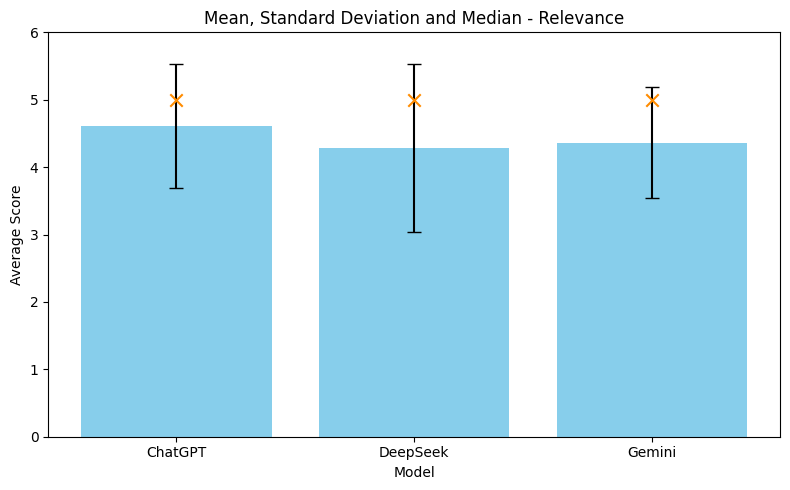

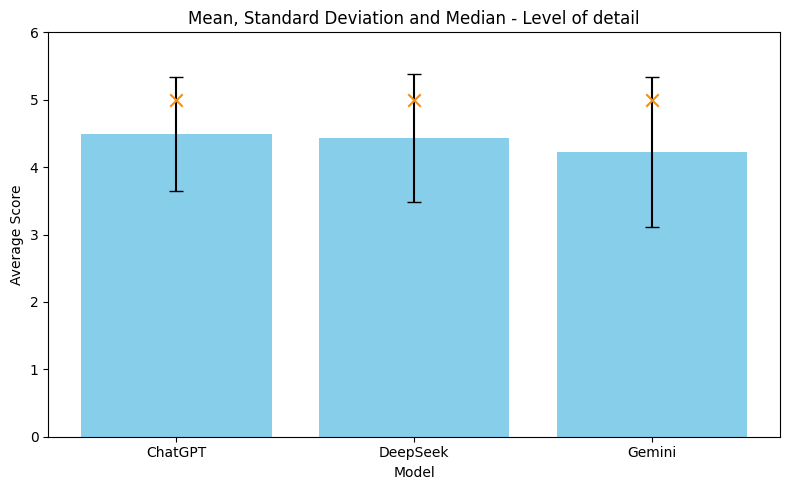

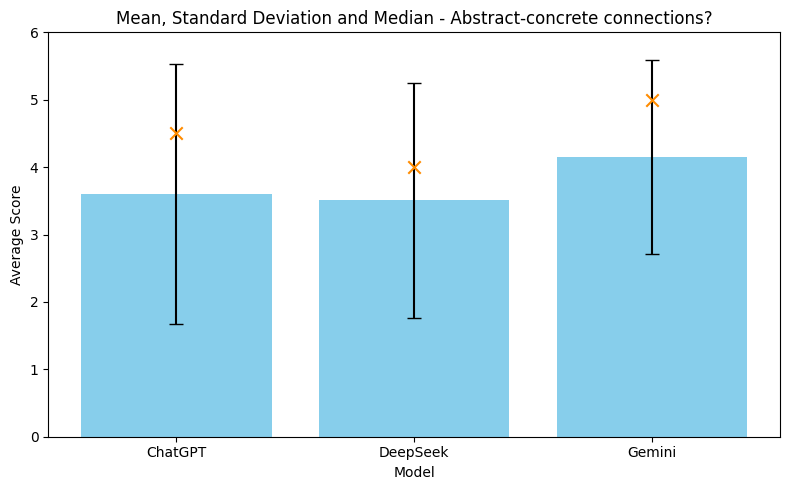

In [ ]:
variaveis = [
    'Relevantes?',
    'São suficientemente detalhados?',
    'Conecta conceitos abstratos e concretos?'
]

#Tradução das variáveis
traducao_var = {
    'Relevantes?': 'Relevance',
    'São suficientemente detalhados?': 'Level of detail',
    'Conecta conceitos abstratos e concretos?': 'Abstract-concrete connections?'
}

#Tradução dos comportamentos (index do DataFrame)
traducao_index = {
    'Exemplos-chatGPT': 'ChatGPT',
    'Exemplos-deepSeek': 'DeepSeek',
    'Exemplos-gemini': 'Gemini'
}

import matplotlib.pyplot as plt

for var in variaveis:
    dados = estatisticas[var]

    # Traduz o índice para exibição
    x_labels = [traducao_index.get(x, x) for x in dados.index]

    plt.figure(figsize=(8, 5))
    plt.bar(x_labels, dados['Média'], yerr=dados['Desvio Padrão'], capsize=5, color='skyblue')

    # Adiciona os pontos de mediana
    plt.scatter(x_labels, dados['Mediana'], color='darkorange',
                marker='x', s=80, label='Mediana', zorder=3)


    plt.title(f"Mean, Standard Deviation and Median - {traducao_var[var]}", fontsize=12)
    plt.ylabel("Average Score")
    plt.xlabel("Model")
    plt.ylim(0, 6)
    plt.grid(axis='y', linestyle='', alpha=0.7)

    plt.tight_layout()
    plt.show()

## Analysis results

## Frequency of Final Decision

In [ ]:
import pandas as pd

resultado = frequencia_decisao_por_modelo(df_exemplos, 'Decisão Final')

# Transforma o dicionário em DataFrame
tabela_frequencias = pd.DataFrame(resultado).T.fillna(0)

# Exibe a tabela
print(tabela_frequencias)

                   Satisfatório  Parcialmente Satisfatório  Insatisfatório
Exemplos-gemini           66.67                      28.00            5.33
Exemplos-chatGPT          70.67                      22.00            7.33
Exemplos-deepSeek         43.33                      38.67           18.00


/tmp/ipython-input-2995919905.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([traducao.get(t.get_text(), t.get_text()) for t in ax.get_xticklabels()])


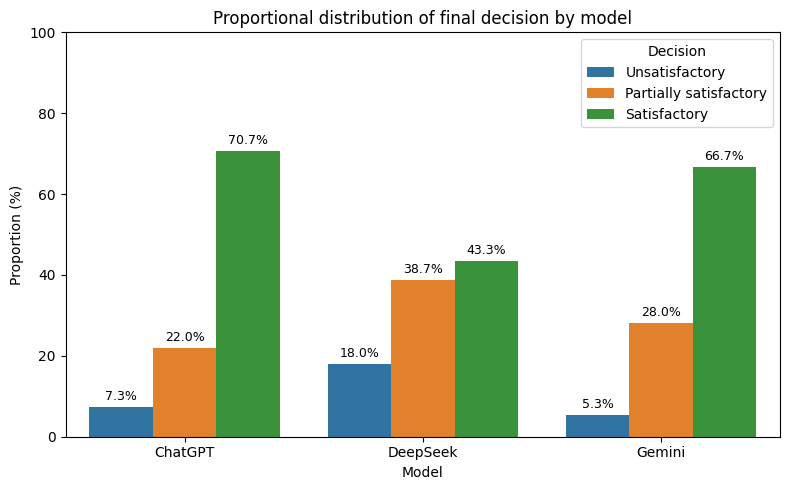

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Dicionários de tradução
traducao = {
    "Exemplos-chatGPT": "ChatGPT",
    "Exemplos-deepSeek": "DeepSeek",
    "Exemplos-gemini": "Gemini"
}

traducao_legenda = {
    "Satisfatório": "Satisfactory",
    "Parcialmente Satisfatório": "Partially satisfactory",
    "Insatisfatório": "Unsatisfactory"
}

# Tabela com proporções
tabela = pd.crosstab(
    df_exemplos["Comportamento-modelo"],
    df_exemplos["Decisão Final"],
    normalize='index'
)

# Long format
df_prop = tabela.reset_index().melt(
    id_vars='Comportamento-modelo',
    var_name='Decisão Final',
    value_name='Proportion'
)

# Tradução da legenda
df_prop["Decisão Final"] = df_prop["Decisão Final"].map(traducao_legenda)

# Converte para %
df_prop["Proportion_pct"] = df_prop["Proportion"] * 100

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=df_prop,
    x="Comportamento-modelo",
    y="Proportion_pct",
    hue="Decisão Final"
)

# Traduz eixo X
ax.set_xticklabels([traducao.get(t.get_text(), t.get_text()) for t in ax.get_xticklabels()])

plt.title("Proportional distribution of final decision by model")
plt.ylabel("Proportion (%)")
plt.xlabel("Model")
plt.ylim(0, 100)
plt.legend(title="Decision")

# Adiciona valores percentuais
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # evita mostrar 0%
        ax.text(
            p.get_x() + p.get_width() / 2.,
            height + 1,             # pequeno deslocamento para não encostar na barra
            f'{height:.1f}%',       # já em %
            ha="center", va="bottom", fontsize=9
        )

plt.tight_layout()
plt.show()


## Frequency of “Provided ready-made answer?”

In [ ]:
import pandas as pd

resultado2 = frequencia_decisao_por_modelo(df_exemplos, 'Forneceu resposta pronta?')

# Transforma o dicionário em DataFrame
tabela_frequencias2 = pd.DataFrame(resultado2).T.fillna(0)

# Exibe a tabela
print(tabela_frequencias2)

                     Não  Parcialmente    Sim
Exemplos-gemini    92.00          6.00   2.00
Exemplos-chatGPT   46.00         32.67  21.33
Exemplos-deepSeek   8.67         20.67  70.67


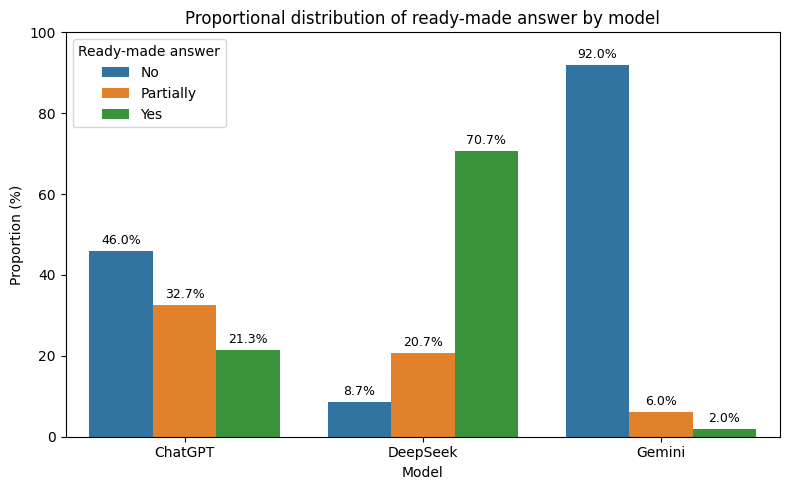

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Dicionários de tradução
traducao_modelo = {
    "Exemplos-chatGPT": "ChatGPT",
    "Exemplos-deepSeek": "DeepSeek",
    "Exemplos-gemini": "Gemini"
}

traducao_resposta = {
    "Sim": "Yes",
    "Parcialmente": "Partially",
    "Não": "No"
}

# Cria tabela com proporções por modelo
tabela = pd.crosstab(
    df_exemplos["Comportamento-modelo"],
    df_exemplos["Forneceu resposta pronta?"],
    normalize='index'
)

# Converte para long format
df_prop = tabela.reset_index().melt(
    id_vars='Comportamento-modelo',
    var_name='Forneceu resposta pronta?',
    value_name='Proporção'
)

# Traduz labels para exibição
df_prop["Comportamento-modelo"] = df_prop["Comportamento-modelo"].map(traducao_modelo)
df_prop["Forneceu resposta pronta?"] = df_prop["Forneceu resposta pronta?"].map(traducao_resposta)

# Multiplica proporção por 100 para exibir %
df_prop["Proporção_pct"] = df_prop["Proporção"] * 100

# Gráfico de barras empilhadas
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=df_prop,
    x="Comportamento-modelo",
    y="Proporção_pct",
    hue="Forneceu resposta pronta?"
)
plt.title("Proportional distribution of ready-made answer by model")
plt.ylabel("Proportion (%)")
plt.xlabel("Model")
plt.ylim(0, 100)
plt.legend(title="Ready-made answer")

# Adiciona os valores percentuais em cima das barras
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(
            p.get_x() + p.get_width() / 2.,  # centraliza na barra
            height + 1,                      # pequeno deslocamento acima da barra
            f'{height:.1f}%',                # exibe em %
            ha="center", va="bottom", fontsize=9
        )

plt.tight_layout()
plt.show()


##Graphs with Kruskal-Wallis + Dunn's test

Relevance: Kruskal-Wallis H=16.3636, p=0.0003
Relevance: Significant Dunn pairs: [('Gemini', 'ChatGPT'), ('ChatGPT', 'DeepSeek')]


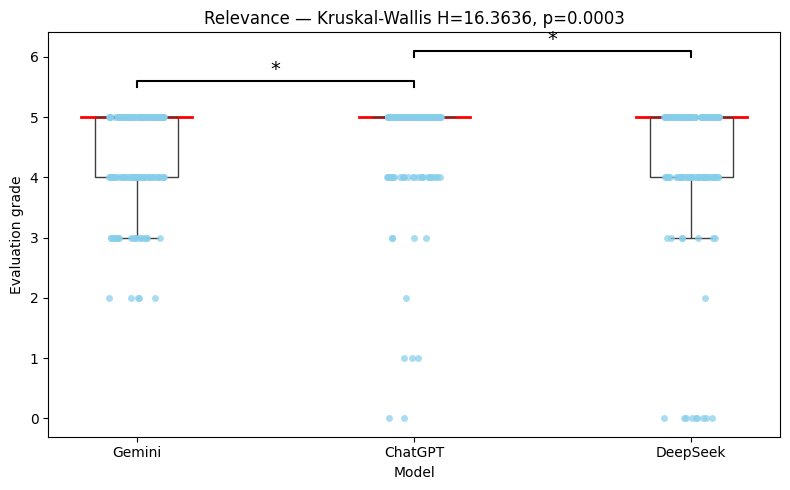

Correctness: Kruskal-Wallis H=5.7260, p=0.0571


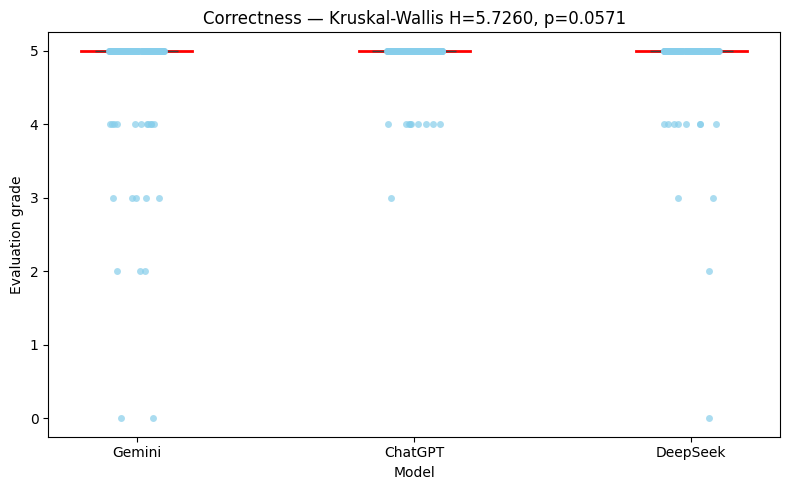

Level of detail: Kruskal-Wallis H=6.1636, p=0.0459
Level of detail: Significant Dunn pairs: []


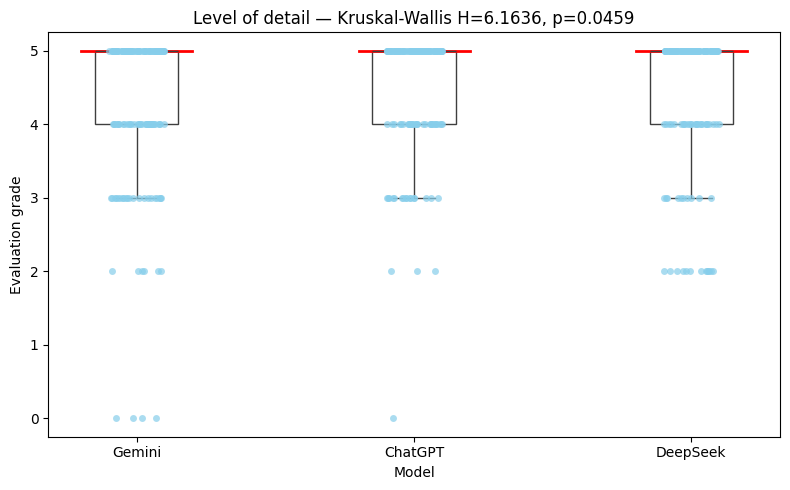

Variety: Kruskal-Wallis H=1.7964, p=0.4073


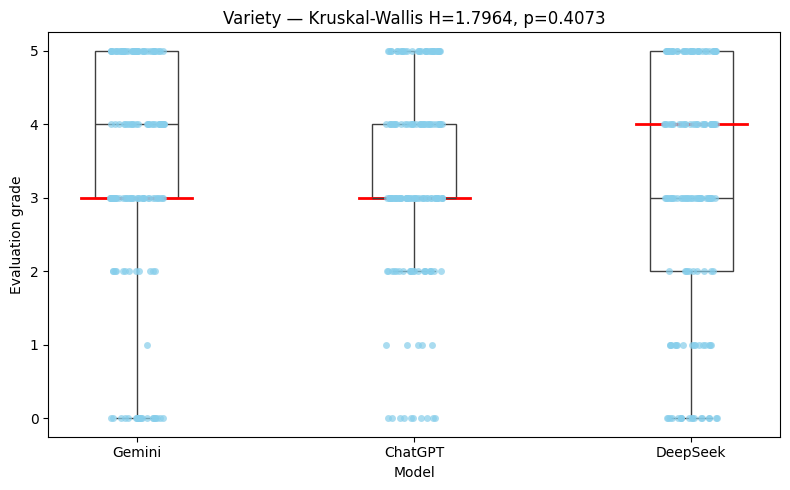

Abstract-concrete connection: Kruskal-Wallis H=13.6923, p=0.0011
Abstract-concrete connection: Significant Dunn pairs: [('Gemini', 'DeepSeek')]


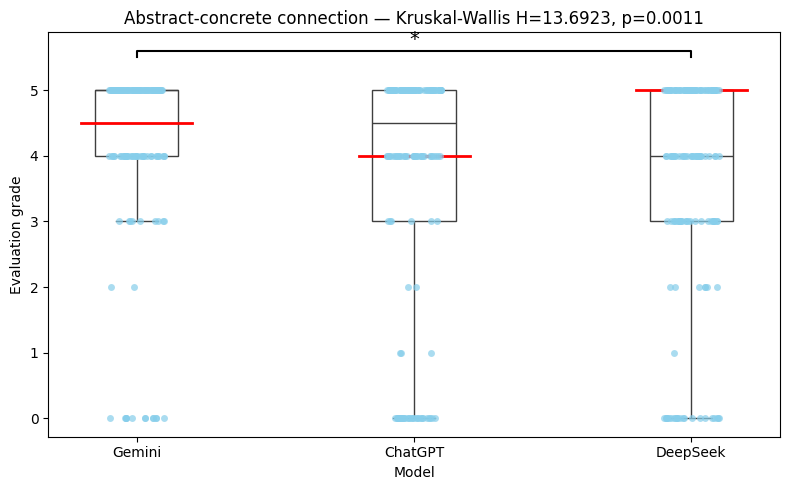

Final average: Kruskal-Wallis H=0.8268, p=0.6614


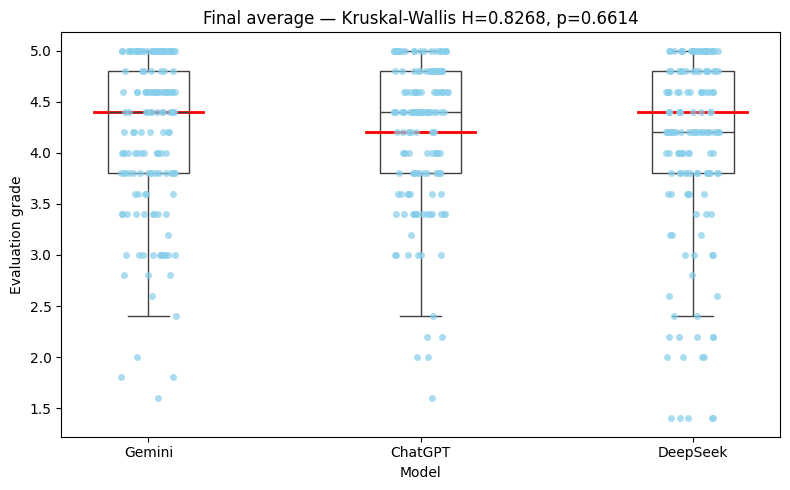

,Variable,H,p
0,Relevance,16.363618,0.000280
1,Correctness,5.725955,0.057099
2,Level of detail,6.163649,0.045875
3,Variety,1.796387,0.407305
4,Abstract-concrete connection,13.692315,0.001064
5,Final average,0.826846,0.661382


In [ ]:
###########################Translation

# Tradução dos títulos das colunas
traducao_colunas = {
    'Comportamento-modelo': 'Model',
    'Relevantes?': 'Relevance',
    'Corretos?': 'Correctness',
    'São suficientemente detalhados?': 'Level of detail',
    'São variados?': 'Variety',
    'Conecta conceitos abstratos e concretos?': 'Abstract-concrete connection',
    'Média Final': 'Final average'
}

# Tradução de termos específicos nas linhas
traducao_linhas = {
    'Exemplos-gemini': 'Gemini',
    'Exemplos-chatGPT': 'ChatGPT',
    'Exemplos-deepSeek': 'DeepSeek'
}


###Tradução das colunas
df_exemplos = df_exemplos.rename(columns=traducao_colunas)

###Tradução das linhas
df_exemplos['Model'] = df_exemplos['Model'].replace(traducao_linhas)

variables = [
    'Relevance', 'Correctness', 'Level of detail',
    'Variety', 'Abstract-concrete connection', 'Final average'
]
for var in variables:
    # Convert to string, replace comma with dot, then convert to float
    df_exemplos[var] = df_exemplos[var].astype(str).str.replace(',', '.').astype(float)

plot_variables_with_dunn(df_exemplos, variables)

## Chi-square test in the end of this colab

# Analysis of **Explanations and Analogies** behavior

##CSV reading

In [ ]:
import pandas as pd

def ler_csv_corrigindo_numeros_explicacoes(caminho_arquivo):
    """
    Lê um CSV com delimitador ';', converte vírgula decimal para ponto
    nas colunas numéricas, e retorna o DataFrame formatado.
    """
    df = pd.read_csv(caminho_arquivo, sep=';')

    # Lista de colunas que devem ser numéricas com vírgula decimal
    colunas_numericas = [
        'Claros, consistentes e fáceis?','Focados?',	'Corretos?',
        'Adaptados ao nível?','Útil?','Conectam com conhecimento prévio?', 'Média Final'
    ]

    for col in colunas_numericas:
        df[col] = df[col].astype(str).str.replace(',', '.').astype(float)

    return df

In [ ]:
# Caminho para o arquivo CSV
df_explicacoes = ler_csv_corrigindo_numeros_explicacoes('avaliacoes_explicacoes.CSV')
print("🔎 Modelos encontrados na coluna 'Comportamento-modelo':")
print(df_explicacoes['Comportamento-modelo'].unique())

🔎 Modelos encontrados na coluna 'Comportamento-modelo':
['Explicações e Analogias-gemini' 'Explicações e Analogias-chatGPT'
 'Explicações e Analogias-deepSee']


In [ ]:
print("📊 Frequência de cada modelo:")
print(df_explicacoes['Comportamento-modelo'].value_counts())

📊 Frequência de cada modelo:
Comportamento-modelo
Explicações e Analogias-gemini     150
Explicações e Analogias-chatGPT    150
Explicações e Analogias-deepSee    150
Name: count, dtype: int64


## Shapiro-wilk test to asses data normality

In [ ]:
resultados = testar_normalidade_por_modelo_e_variavel(df_explicacoes,['Claros, consistentes e fáceis?','Focados?','Corretos?','Adaptados ao nível?','Útil?','Conectam com conhecimento prévio?','Média Final'])
# Exibindo os resultados de forma clara
for modelo, variaveis in resultados.items():
    print(f"\n📘 Modelo: {modelo}")
    for variavel, resultado in variaveis.items():
        print(f"  ➤ {variavel}: {resultado}")


📘 Modelo: Explicações e Analogias-gemini
  ➤ Claros, consistentes e fáceis?: {'stat': np.float64(0.5848), 'p-valor': np.float64(0.0), 'distribuicao': 'Não normal'}
  ➤ Focados?: {'stat': np.float64(0.4536), 'p-valor': np.float64(0.0), 'distribuicao': 'Não normal'}
  ➤ Corretos?: {'stat': np.float64(0.322), 'p-valor': np.float64(0.0), 'distribuicao': 'Não normal'}
  ➤ Adaptados ao nível?: {'stat': np.float64(0.4706), 'p-valor': np.float64(0.0), 'distribuicao': 'Não normal'}
  ➤ Útil?: {'stat': np.float64(0.7276), 'p-valor': np.float64(0.0), 'distribuicao': 'Não normal'}
  ➤ Conectam com conhecimento prévio?: {'stat': np.float64(0.6128), 'p-valor': np.float64(0.0), 'distribuicao': 'Não normal'}
  ➤ Média Final: {'stat': np.float64(0.6022), 'p-valor': np.float64(0.0), 'distribuicao': 'Não normal'}

📘 Modelo: Explicações e Analogias-chatGPT
  ➤ Claros, consistentes e fáceis?: {'stat': np.float64(0.6489), 'p-valor': np.float64(0.0), 'distribuicao': 'Não normal'}
  ➤ Focados?: {'stat': np.f

##Kruskal-wallis test by final average

In [ ]:
resultado_kruskal = teste_kruskal_media_final(df_explicacoes)
print("🔎 Resultado do teste de Kruskal-Wallis:")
print(resultado_kruskal)

📊 Tamanhos dos grupos usados no teste:
  - Explicações e Analogias-chatGPT: 150 valores
  - Explicações e Analogias-deepSee: 150 valores
  - Explicações e Analogias-gemini: 150 valores
🔎 Resultado do teste de Kruskal-Wallis:
{'estatística H': np.float64(7.0449), 'p-valor': np.float64(0.0295), 'diferença significativa': 'Sim'}


**Há diferença significativa por Média Final**

## Dunn’s post hoc test to identify differences between model pairs (variables with significant differences) by final average

In [ ]:
# Exibindo os resultados
for var, resultado in resultados_dunn.items():
    print(f"\n🔍 Teste de Dunn — Variável: {var}")

    # Caso tenha ocorrido erro ou dados insuficientes
    if not isinstance(resultado, dict):
        print(f"⚠️ {resultado}")
        continue

    # Exibir p-valores brutos
    print("\n📊 P-valores não ajustados:")
    display(resultado['p_raw'])  # em Jupyter / Colab
    # ou print(resultado['p_raw']) para terminal simples

    # Exibir p-valores ajustados
    chave_ajuste = [k for k in resultado.keys() if k.startswith('p_ajustado_')][0]
    print(f"\n📈 P-valores ajustados ({chave_ajuste.replace('p_ajustado_', '')}):")
    display(resultado[chave_ajuste])


🔍 Teste de Dunn — Variável: Relevantes?

📊 P-valores não ajustados:


,Exemplos-chatGPT,Exemplos-deepSeek,Exemplos-gemini
Exemplos-chatGPT,1.000000,0.001705,0.000157
Exemplos-deepSeek,0.001705,1.000000,0.520348
Exemplos-gemini,0.000157,0.520348,1.000000



📈 P-valores ajustados (bonferroni):


,Exemplos-chatGPT,Exemplos-deepSeek,Exemplos-gemini
Exemplos-chatGPT,1.000000,0.005115,0.00047
Exemplos-deepSeek,0.005115,1.000000,1.00000
Exemplos-gemini,0.000470,1.000000,1.00000



🔍 Teste de Dunn — Variável: São suficientemente detalhados?

📊 P-valores não ajustados:


,Exemplos-chatGPT,Exemplos-deepSeek,Exemplos-gemini
Exemplos-chatGPT,1.000000,0.793472,0.023270
Exemplos-deepSeek,0.793472,1.000000,0.044732
Exemplos-gemini,0.023270,0.044732,1.000000



📈 P-valores ajustados (bonferroni):


,Exemplos-chatGPT,Exemplos-deepSeek,Exemplos-gemini
Exemplos-chatGPT,1.000000,1.000000,0.069811
Exemplos-deepSeek,1.000000,1.000000,0.134196
Exemplos-gemini,0.069811,0.134196,1.000000



🔍 Teste de Dunn — Variável: Conecta conceitos abstratos e concretos?

📊 P-valores não ajustados:


,Exemplos-chatGPT,Exemplos-deepSeek,Exemplos-gemini
Exemplos-chatGPT,1.000000,0.125699,0.031425
Exemplos-deepSeek,0.125699,1.000000,0.000231
Exemplos-gemini,0.031425,0.000231,1.000000



📈 P-valores ajustados (bonferroni):


,Exemplos-chatGPT,Exemplos-deepSeek,Exemplos-gemini
Exemplos-chatGPT,1.000000,0.377096,0.094274
Exemplos-deepSeek,0.377096,1.000000,0.000692
Exemplos-gemini,0.094274,0.000692,1.000000


## Mean and standard deviation

In [ ]:
print("📊 Estatísticas da variável 'Média Final':")

estatisticas = df_explicacoes.groupby('Comportamento-modelo')['Média Final'].agg(['mean', 'std','median'])
estatisticas = estatisticas.rename(columns={'mean': 'Média', 'std': 'Desvio Padrão', 'median': 'Mediana'})

# Arredonda para 3 casas decimais
estatisticas = estatisticas.round(3)

display (estatisticas)

📊 Estatísticas da variável 'Média Final':


,Média,Desvio Padrão,Mediana
Comportamento-modelo,,,
Explicações e Analogias-chatGPT,4.591,0.413,4.667
Explicações e Analogias-deepSee,4.364,0.645,4.667
Explicações e Analogias-gemini,4.347,1.016,4.667


## Kruskal-Wallis test by evaluated variables

In [ ]:
variaveis = [
    'Claros, consistentes e fáceis?','Focados?','Corretos?','Adaptados ao nível?','Útil?','Conectam com conhecimento prévio?'
]

resultado_variaveis = testar_kruskal_variaveis(df_explicacoes, variaveis)

# Exibir resultados
for var, info in resultado_variaveis.items():
    print(f"\n📌 Variável: {var}")
    if isinstance(info, dict):
        if 'p-valor' in info:
            print(f"  ➤ Estatística H: {info['estatística H']}")
            print(f"  ➤ p-valor: {info['p-valor']}")
            print(f"  ➤ Diferença significativa? {info['diferença significativa']}")
        else:
            print(f"  ➤ {info['resultado']}")

        print("  ➤ Tamanho dos grupos:")
        for modelo, tamanho in info['tamanhos'].items():
            print(f"     - {modelo}: {tamanho} valores")



📌 Variável: Claros, consistentes e fáceis?
  ➤ Estatística H: 7.6037
  ➤ p-valor: 0.0223
  ➤ Diferença significativa? Sim
  ➤ Tamanho dos grupos:
     - Explicações e Analogias-chatGPT: 150 valores
     - Explicações e Analogias-deepSee: 150 valores
     - Explicações e Analogias-gemini: 150 valores

📌 Variável: Focados?
  ➤ Estatística H: 53.9816
  ➤ p-valor: 0.0
  ➤ Diferença significativa? Sim
  ➤ Tamanho dos grupos:
     - Explicações e Analogias-chatGPT: 150 valores
     - Explicações e Analogias-deepSee: 150 valores
     - Explicações e Analogias-gemini: 150 valores

📌 Variável: Corretos?
  ➤ Estatística H: 1.3195
  ➤ p-valor: 0.517
  ➤ Diferença significativa? Não
  ➤ Tamanho dos grupos:
     - Explicações e Analogias-chatGPT: 150 valores
     - Explicações e Analogias-deepSee: 150 valores
     - Explicações e Analogias-gemini: 150 valores

📌 Variável: Adaptados ao nível?
  ➤ Estatística H: 13.8414
  ➤ p-valor: 0.001
  ➤ Diferença significativa? Sim
  ➤ Tamanho dos grupos:
    

## Dunn’s post hoc test to identify differences between model pairs (variables with significant differences)

In [ ]:
# Liste aqui apenas as variáveis que deram p < 0.05 no Kruskal
variaveis_significativas = [
    'Claros, consistentes e fáceis?','Focados?','Adaptados ao nível?','Útil?', 'Média Final'
]

# Roda o teste de Dunn
resultados_dunn = aplicar_teste_dunn_variaveis(df_explicacoes, variaveis_significativas)

# Exibindo os resultados
for var, resultado in resultados_dunn.items():
    print(f"\n🔍 Teste de Dunn — Variável: {var}")

    # Caso tenha ocorrido erro ou dados insuficientes
    if not isinstance(resultado, dict):
        print(f"⚠️ {resultado}")
        continue

    # Exibir p-valores brutos
    print("\n📊 P-valores não ajustados:")
    display(resultado['p_raw'])  # em Jupyter / Colab
    # ou print(resultado['p_raw']) para terminal simples

    # Exibir p-valores ajustados
    chave_ajuste = [k for k in resultado.keys() if k.startswith('p_ajustado_')][0]
    print(f"\n📈 P-valores ajustados ({chave_ajuste.replace('p_ajustado_', '')}):")
    display(resultado[chave_ajuste])


🔍 Teste de Dunn — Variável: Claros, consistentes e fáceis?

📊 P-valores não ajustados:


,Explicações e Analogias-chatGPT,Explicações e Analogias-deepSee,Explicações e Analogias-gemini
Explicações e Analogias-chatGPT,1.000000,0.008722,0.565940
Explicações e Analogias-deepSee,0.008722,1.000000,0.040491
Explicações e Analogias-gemini,0.565940,0.040491,1.000000



📈 P-valores ajustados (bonferroni):


,Explicações e Analogias-chatGPT,Explicações e Analogias-deepSee,Explicações e Analogias-gemini
Explicações e Analogias-chatGPT,1.000000,0.026167,1.000000
Explicações e Analogias-deepSee,0.026167,1.000000,0.121472
Explicações e Analogias-gemini,1.000000,0.121472,1.000000



🔍 Teste de Dunn — Variável: Focados?

📊 P-valores não ajustados:


,Explicações e Analogias-chatGPT,Explicações e Analogias-deepSee,Explicações e Analogias-gemini
Explicações e Analogias-chatGPT,1.000000e+00,8.329852e-13,3.282913e-02
Explicações e Analogias-deepSee,8.329852e-13,1.000000e+00,5.128330e-07
Explicações e Analogias-gemini,3.282913e-02,5.128330e-07,1.000000e+00



📈 P-valores ajustados (bonferroni):


,Explicações e Analogias-chatGPT,Explicações e Analogias-deepSee,Explicações e Analogias-gemini
Explicações e Analogias-chatGPT,1.000000e+00,2.498956e-12,0.098487
Explicações e Analogias-deepSee,2.498956e-12,1.000000e+00,0.000002
Explicações e Analogias-gemini,9.848738e-02,1.538499e-06,1.000000



🔍 Teste de Dunn — Variável: Adaptados ao nível?

📊 P-valores não ajustados:


,Explicações e Analogias-chatGPT,Explicações e Analogias-deepSee,Explicações e Analogias-gemini
Explicações e Analogias-chatGPT,1.000000,0.001915,0.821378
Explicações e Analogias-deepSee,0.001915,1.000000,0.000872
Explicações e Analogias-gemini,0.821378,0.000872,1.000000



📈 P-valores ajustados (bonferroni):


,Explicações e Analogias-chatGPT,Explicações e Analogias-deepSee,Explicações e Analogias-gemini
Explicações e Analogias-chatGPT,1.000000,0.005744,1.000000
Explicações e Analogias-deepSee,0.005744,1.000000,0.002616
Explicações e Analogias-gemini,1.000000,0.002616,1.000000



🔍 Teste de Dunn — Variável: Útil?

📊 P-valores não ajustados:


,Explicações e Analogias-chatGPT,Explicações e Analogias-deepSee,Explicações e Analogias-gemini
Explicações e Analogias-chatGPT,1.000000e+00,0.000157,7.001678e-07
Explicações e Analogias-deepSee,1.567341e-04,1.000000,2.375363e-01
Explicações e Analogias-gemini,7.001678e-07,0.237536,1.000000e+00



📈 P-valores ajustados (bonferroni):


,Explicações e Analogias-chatGPT,Explicações e Analogias-deepSee,Explicações e Analogias-gemini
Explicações e Analogias-chatGPT,1.000000,0.000470,0.000002
Explicações e Analogias-deepSee,0.000470,1.000000,0.712609
Explicações e Analogias-gemini,0.000002,0.712609,1.000000



🔍 Teste de Dunn — Variável: Média Final

📊 P-valores não ajustados:


,Explicações e Analogias-chatGPT,Explicações e Analogias-deepSee,Explicações e Analogias-gemini
Explicações e Analogias-chatGPT,1.000000,0.007949,0.186622
Explicações e Analogias-deepSee,0.007949,1.000000,0.182342
Explicações e Analogias-gemini,0.186622,0.182342,1.000000



📈 P-valores ajustados (bonferroni):


,Explicações e Analogias-chatGPT,Explicações e Analogias-deepSee,Explicações e Analogias-gemini
Explicações e Analogias-chatGPT,1.000000,0.023848,0.559867
Explicações e Analogias-deepSee,0.023848,1.000000,0.547025
Explicações e Analogias-gemini,0.559867,0.547025,1.000000


## Mean and standard deviation per variable with statistical difference

In [ ]:
variaveis = [
    'Claros, consistentes e fáceis?','Focados?','Corretos?','Adaptados ao nível?','Útil?','Conectam com conhecimento prévio?', 'Média Final'
]

estatisticas = medias_e_desvios_por_modelo(df_explicacoes, variaveis)

print("📊 Estatísticas da variável 'Claros, consistentes e fáceis?':")
print(estatisticas['Claros, consistentes e fáceis?'].round(3))

print("📊 Estatísticas da variável 'Focados?':")
print(estatisticas['Focados?'].round(3))

print("📊 Estatísticas da variável 'Corretos?':")
print(estatisticas['Corretos?'].round(3))

print("📊 Estatísticas da variável 'Adaptados ao nível?':")
print(estatisticas['Adaptados ao nível?'].round(3))

print("📊 Estatísticas da variável 'Útil?':")
print(estatisticas['Útil?'].round(3))

print("📊 Estatísticas da variável 'Conectam com conhecimento prévio?':")
print(estatisticas['Conectam com conhecimento prévio?'].round(3))

📊 Estatísticas da variável 'Claros, consistentes e fáceis?':
                                 Média  Desvio Padrão  Mediana
Comportamento-modelo                                          
Explicações e Analogias-chatGPT  4.607          0.612      5.0
Explicações e Analogias-deepSee  4.340          0.866      5.0
Explicações e Analogias-gemini   4.387          1.157      5.0
📊 Estatísticas da variável 'Focados?':
                                 Média  Desvio Padrão  Mediana
Comportamento-modelo                                          
Explicações e Analogias-chatGPT  4.880          0.383      5.0
Explicações e Analogias-deepSee  4.273          0.969      5.0
Explicações e Analogias-gemini   4.540          1.156      5.0
📊 Estatísticas da variável 'Corretos?':
                                 Média  Desvio Padrão  Mediana
Comportamento-modelo                                          
Explicações e Analogias-chatGPT  4.893          0.369      5.0
Explicações e Analogias-deepSee  4.840   

##Graphs with mean and standard deviation per variable

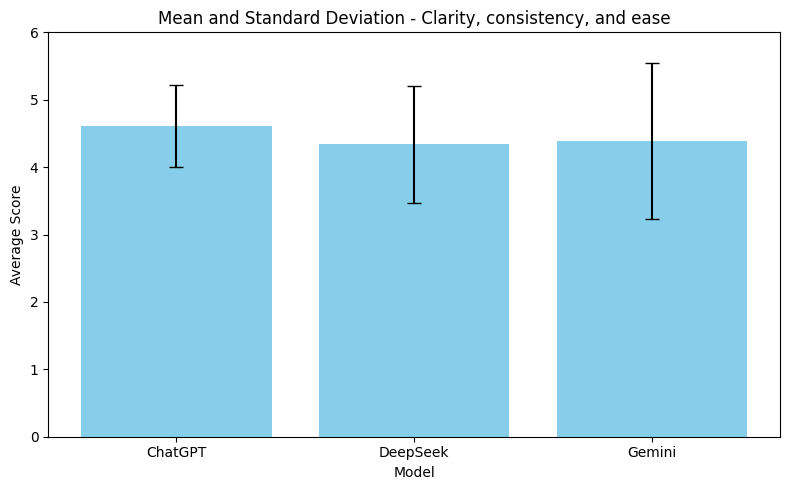

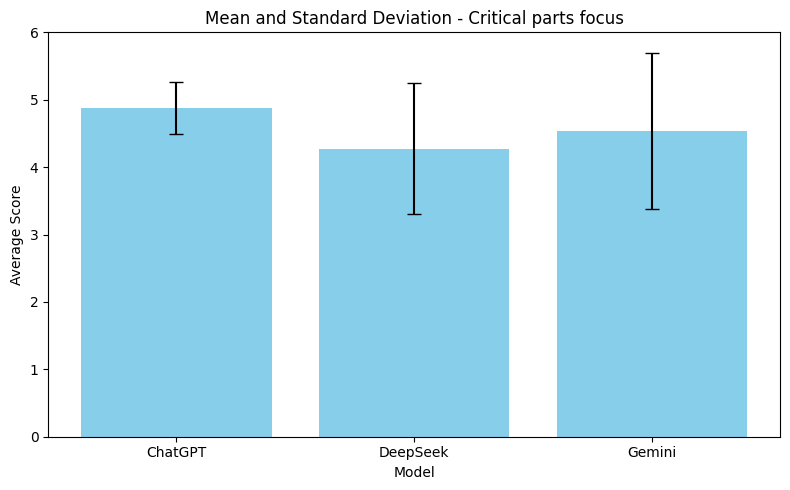

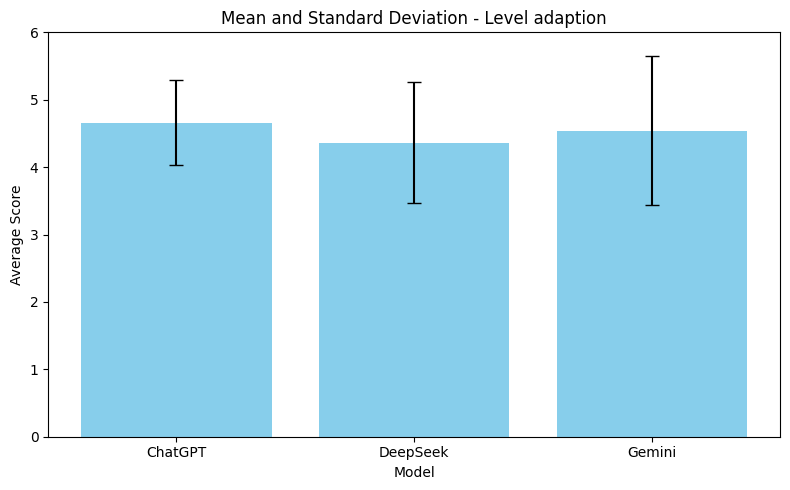

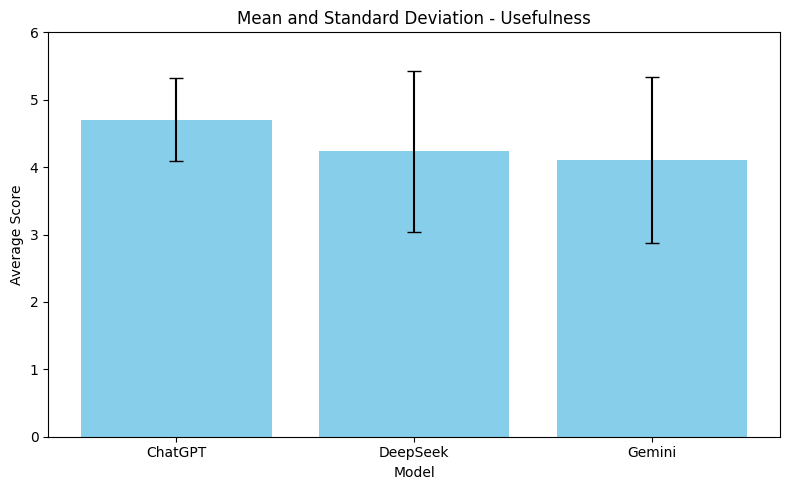

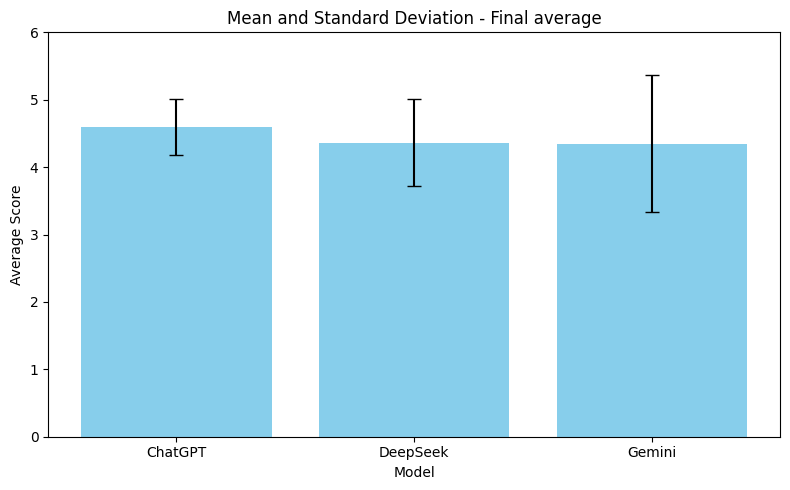

In [ ]:
variaveis = [
    'Claros, consistentes e fáceis?','Focados?','Adaptados ao nível?','Útil?', 'Média Final'
]


#Tradução das variáveis
traducao_var = {
    'Claros, consistentes e fáceis?': 'Clarity, consistency, and ease' ,
    'Focados?': 'Critical parts focus',
    'Adaptados ao nível?': 'Level adaption',
    'Útil?': 'Usefulness',
    'Média Final': 'Final average'
}

#Tradução dos comportamentos (index do DataFrame)
traducao_index = {
    'Explicações e Analogias-chatGPT': 'ChatGPT',
    'Explicações e Analogias-deepSee': 'DeepSeek',
    'Explicações e Analogias-gemini': 'Gemini'
}

import matplotlib.pyplot as plt

for var in variaveis:
    dados = estatisticas[var]

    # Traduz o índice para exibição
    x_labels = [traducao_index.get(x, x) for x in dados.index]

    plt.figure(figsize=(8, 5))
    plt.bar(x_labels, dados['Média'], yerr=dados['Desvio Padrão'], capsize=5, color='skyblue')

    plt.title(f"Mean and Standard Deviation - {traducao_var[var]}", fontsize=12)
    plt.ylabel("Average Score")
    plt.xlabel("Model")
    plt.ylim(0, 6)
    plt.grid(axis='y', linestyle='', alpha=0.7)

    plt.tight_layout()
    plt.show()

##Verification of the use of analogies and explanations by the models

In [ ]:
#Analisar dados das colunas "Apresenta analogia" e "Apresenta explicação"
import pandas as pd
import matplotlib.pyplot as plt

# Criando o DataFrame
dados = {
    'Característica': ['Característica 1', 'Característica 2'],
    'A': [79.3, 100.0],
    'B': [83.3, 89.4],
    'C': [89.3, 98.7]
}

df = pd.DataFrame(dados)



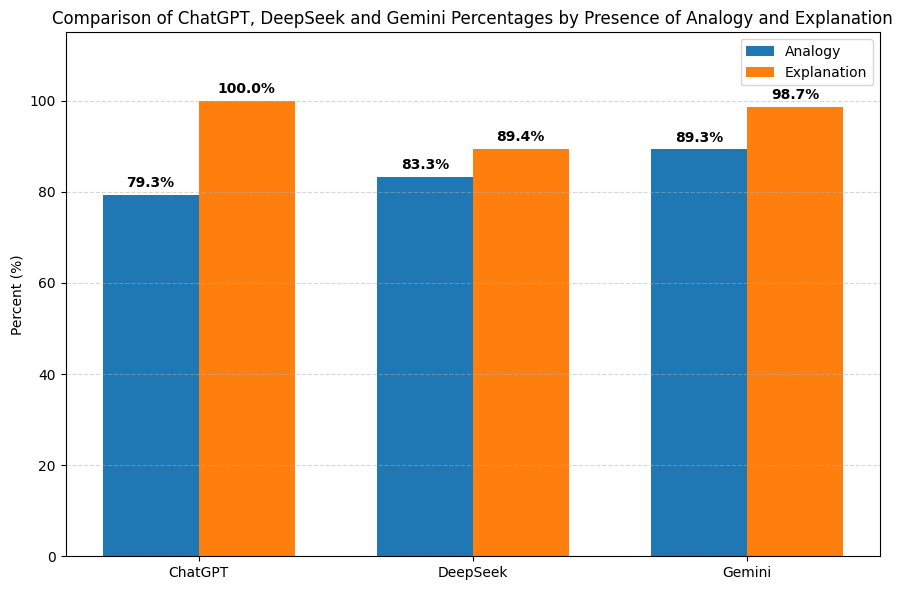

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Criando o DataFrame
dados = {
    'Criterion': ['Analogy', 'Explanation'],
    'ChatGPT': [79.3, 100.0],
    'DeepSeek': [83.3, 89.4],
    'Gemini': [89.3, 98.7]
}

df = pd.DataFrame(dados)

# Transpondo o DataFrame para que A, B, C fiquem no eixo X
df_transposto = df.set_index('Criterion').T

# Configurações iniciais
plt.figure(figsize=(9, 6))
largura_barra = 0.35
posicoes = np.arange(len(df_transposto))

# Cores personalizadas
cores = ['#1f77b4', '#ff7f0e']

# Plotando as barras: agora cada característica é uma série
barras1 = plt.bar(posicoes - largura_barra/2, df_transposto['Analogy'], width=largura_barra, label='Analogy', color=cores[0])
barras2 = plt.bar(posicoes + largura_barra/2, df_transposto['Explanation'], width=largura_barra, label='Explanation', color=cores[1])

# Adicionando os percentuais nas barras
def adicionar_rotulos(barras):
    for barra in barras:
        altura = barra.get_height()
        plt.text(
            barra.get_x() + barra.get_width()/2,
            altura + 1,
            f'{altura:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold'
        )

adicionar_rotulos(barras1)
adicionar_rotulos(barras2)

# Configurações do gráfico
plt.xticks(posicoes, df_transposto.index)
plt.ylabel('Percent (%)')
#plt.xlabel('Criterion')
plt.title('Comparison of ChatGPT, DeepSeek and Gemini Percentages by Presence of Analogy and Explanation')
plt.ylim(0, 115)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Exibir gráfico
plt.tight_layout()
plt.show()


## Analysis results

## Frequency of Final Decision by Model (Judges' perception)

In [ ]:
import pandas as pd

resultado = frequencia_decisao_por_modelo(df_explicacoes, 'Decisão Final')

# Transforma o dicionário em DataFrame
tabela_frequencias = pd.DataFrame(resultado).T.fillna(0)

# Exibe a tabela
display(tabela_frequencias)

,Satisfatório,Parcialmente Satisfatório,Insatisfatório
Explicações e Analogias-gemini,67.11,30.87,2.01
Explicações e Analogias-chatGPT,73.33,26.00,0.67
Explicações e Analogias-deepSee,44.00,39.33,16.67


/tmp/ipython-input-481905667.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([traducao.get(t.get_text(), t.get_text()) for t in ax.get_xticklabels()])


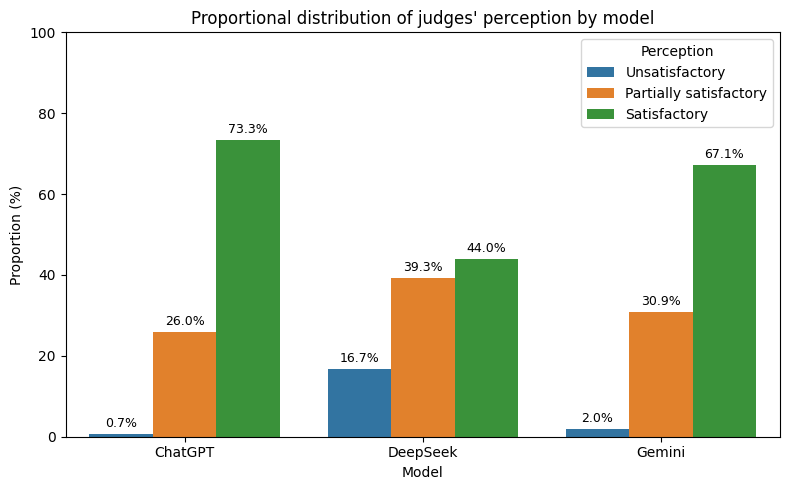

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Dicionários de tradução
traducao = {
    "Explicações e Analogias-chatGPT": "ChatGPT",
    "Explicações e Analogias-deepSee": "DeepSeek",
    "Explicações e Analogias-gemini": "Gemini"
}

traducao_legenda = {
    "Satisfatório": "Satisfactory",
    "Parcialmente Satisfatório": "Partially satisfactory",
    "Insatisfatório": "Unsatisfactory"
}

# Tabela com proporções
tabela = pd.crosstab(
    df_explicacoes["Comportamento-modelo"],
    df_explicacoes["Decisão Final"],
    normalize='index'
)

# Long format
df_prop = tabela.reset_index().melt(
    id_vars='Comportamento-modelo',
    var_name='Decisão Final',
    value_name='Proportion'
)

# Tradução da legenda
df_prop["Decisão Final"] = df_prop["Decisão Final"].map(traducao_legenda)

# Converte para %
df_prop["Proportion_pct"] = df_prop["Proportion"] * 100

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=df_prop,
    x="Comportamento-modelo",
    y="Proportion_pct",
    hue="Decisão Final"
)

# Traduz eixo X
ax.set_xticklabels([traducao.get(t.get_text(), t.get_text()) for t in ax.get_xticklabels()])

plt.title("Proportional distribution of judges' perception by model")
plt.ylabel("Proportion (%)")
plt.xlabel("Model")
plt.ylim(0, 100)
plt.legend(title="Perception")

# Adiciona valores percentuais
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # evita mostrar 0%
        ax.text(
            p.get_x() + p.get_width() / 2.,
            height + 1,             # pequeno deslocamento para não encostar na barra
            f'{height:.1f}%',       # já em %
            ha="center", va="bottom", fontsize=9
        )

plt.tight_layout()
plt.show()

## Frequency of “Provided immediate solution”

In [ ]:
import pandas as pd

resultado2 = frequencia_decisao_por_modelo(df_explicacoes, 'Forneceu resposta pronta?')

# Transforma o dicionário em DataFrame
tabela_frequencias2 = pd.DataFrame(resultado2).T.fillna(0)

# Exibe a tabela
print(tabela_frequencias2)

                                   Não  Parcialmente    Sim
Explicações e Analogias-gemini   86.00         14.00   0.00
Explicações e Analogias-chatGPT  80.00         17.33   2.67
Explicações e Analogias-deepSee  14.67         23.33  62.00


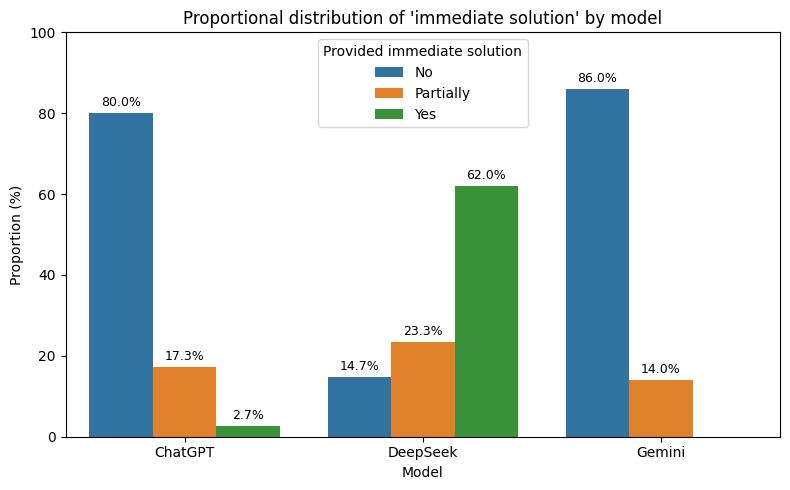

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Dicionários de tradução
traducao_modelo = {
    "Explicações e Analogias-chatGPT": "ChatGPT",
    "Explicações e Analogias-deepSee": "DeepSeek",
    "Explicações e Analogias-gemini": "Gemini"
}

traducao_resposta = {
    "Sim": "Yes",
    "Parcialmente": "Partially",
    "Não": "No"
}

# Cria tabela com proporções por modelo
tabela = pd.crosstab(
    df_explicacoes["Comportamento-modelo"],
    df_explicacoes["Forneceu resposta pronta?"],
    normalize='index'
)

# Converte para long format
df_prop = tabela.reset_index().melt(
    id_vars='Comportamento-modelo',
    var_name='Forneceu resposta pronta?',
    value_name='Proporção'
)

# Traduz labels para exibição
df_prop["Comportamento-modelo"] = df_prop["Comportamento-modelo"].map(traducao_modelo)
df_prop["Forneceu resposta pronta?"] = df_prop["Forneceu resposta pronta?"].map(traducao_resposta)

# Multiplica proporção por 100 para exibir %
df_prop["Proporção_pct"] = df_prop["Proporção"] * 100

# Gráfico de barras empilhadas
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=df_prop,
    x="Comportamento-modelo",
    y="Proporção_pct",
    hue="Forneceu resposta pronta?"
)
plt.title("Proportional distribution of 'immediate solution' by model")
plt.ylabel("Proportion (%)")
plt.xlabel("Model")
plt.ylim(0, 100)
plt.legend(title="Provided immediate solution")

# Adiciona os valores percentuais em cima das barras
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(
            p.get_x() + p.get_width() / 2.,  # centraliza na barra
            height + 1,                      # pequeno deslocamento acima da barra
            f'{height:.1f}%',                # exibe em %
            ha="center", va="bottom", fontsize=9
        )

plt.tight_layout()
plt.show()

## Graphs with Kruskal-Wallis + Dunn's test

Clarity, consistency, and ease: Kruskal-Wallis H=7.6037, p=0.0223
Clarity, consistency, and ease: Significant Dunn pairs: [('ChatGPT', 'DeepSeek')]


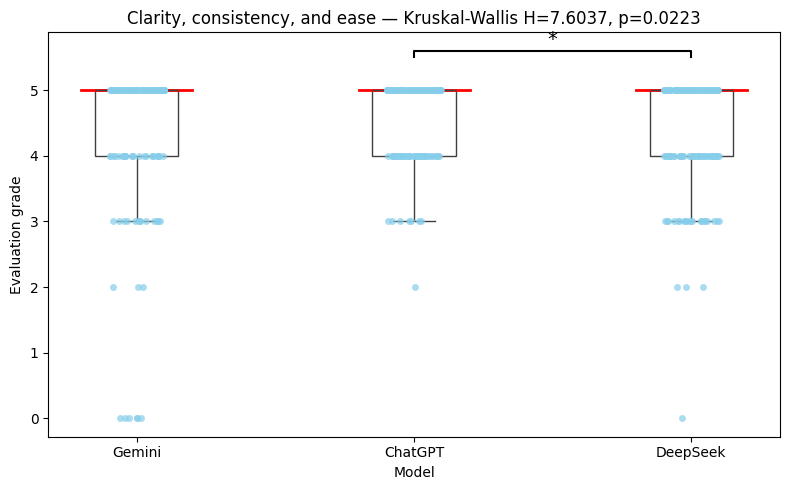

Critical parts focus: Kruskal-Wallis H=53.9816, p=0.0000
Critical parts focus: Significant Dunn pairs: [('Gemini', 'DeepSeek'), ('ChatGPT', 'DeepSeek')]


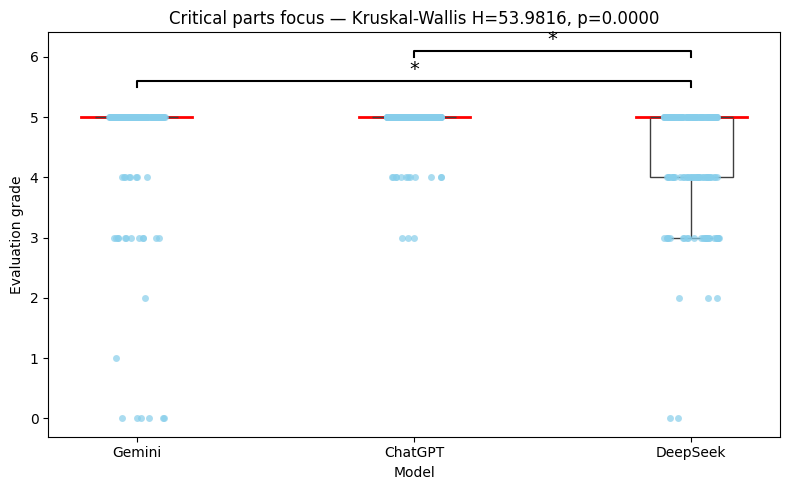

Correctness: Kruskal-Wallis H=1.3195, p=0.5170


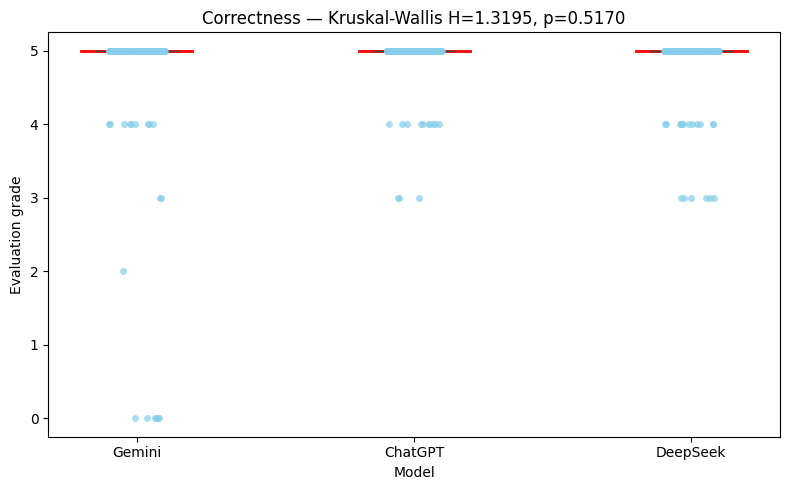

Level adaptation: Kruskal-Wallis H=13.8414, p=0.0010
Level adaptation: Significant Dunn pairs: [('Gemini', 'DeepSeek'), ('ChatGPT', 'DeepSeek')]


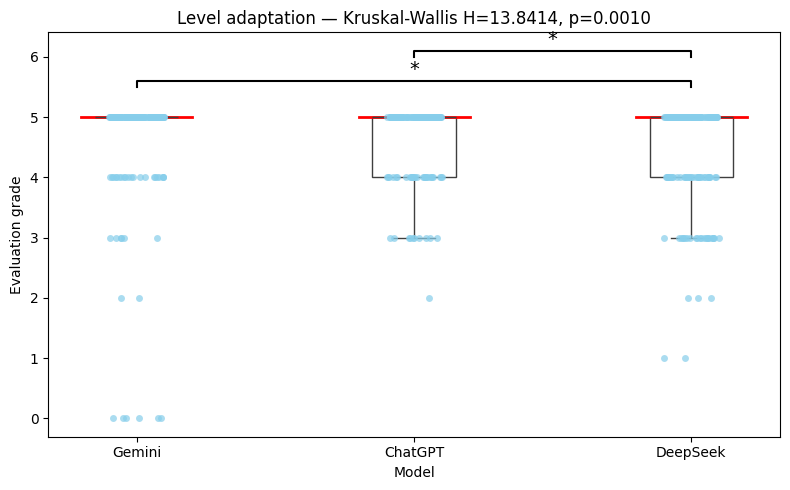

Usefulness: Kruskal-Wallis H=26.8662, p=0.0000
Usefulness: Significant Dunn pairs: [('Gemini', 'ChatGPT'), ('ChatGPT', 'DeepSeek')]


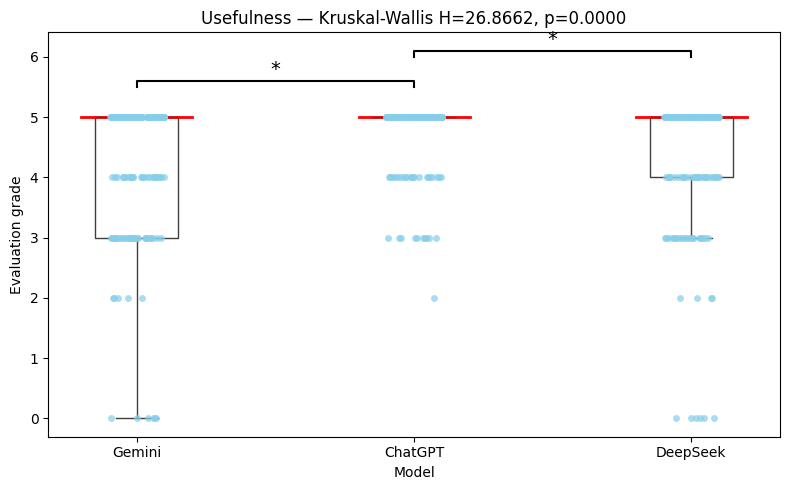

Previous knowledge connection: Kruskal-Wallis H=0.3882, p=0.8236


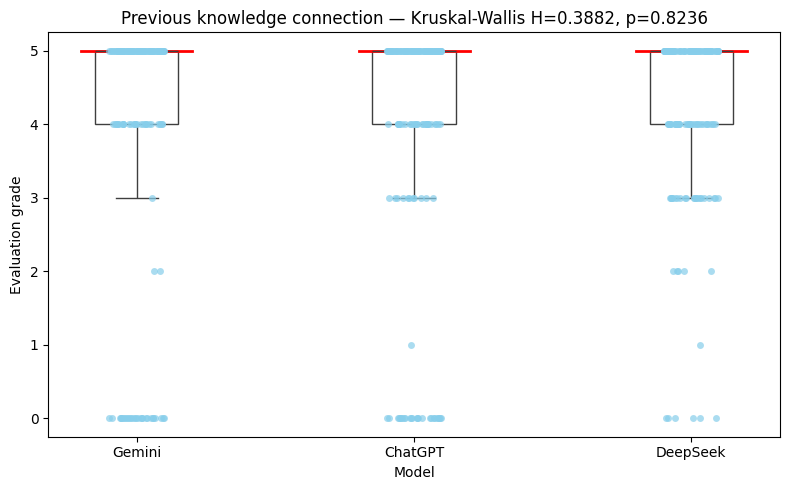

Final average: Kruskal-Wallis H=7.0449, p=0.0295
Final average: Significant Dunn pairs: [('ChatGPT', 'DeepSeek')]


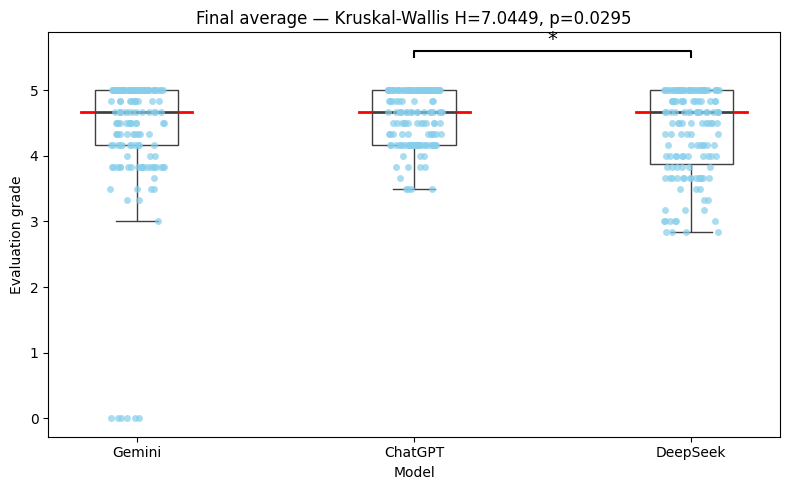

,Variable,H,p
0,"Clarity, consistency, and ease",7.603698,2.232945e-02
1,Critical parts focus,53.981626,1.896875e-12
2,Correctness,1.319458,5.169914e-01
3,Level adaptation,13.841394,9.871415e-04
4,Usefulness,26.866237,1.465787e-06
5,Previous knowledge connection,0.388151,8.235958e-01
6,Final average,7.044924,2.952665e-02


In [ ]:
df_explicacoes = ler_csv_corrigindo_numeros_explicacoes('avaliacoes_explicacoes.CSV')

###########################Translation
# Tradução dos títulos das colunas
traducao_colunas = {
    'Comportamento-modelo': 'Model',
    'Claros, consistentes e fáceis?': 'Clarity, consistency, and ease',
    'Focados?': 'Critical parts focus',
    'Corretos?': 'Correctness',
    'Adaptados ao nível?': 'Level adaptation',
    'Útil?': 'Usefulness',
    'Conectam com conhecimento prévio?': 'Previous knowledge connection',
    'Média Final': 'Final average'
}

# Tradução de termos específicos nas linhas
traducao_linhas = {
    "Explicações e Analogias-chatGPT": "ChatGPT",
    "Explicações e Analogias-deepSee": "DeepSeek",
    "Explicações e Analogias-gemini": "Gemini"
}


###Tradução das colunas
df_explicacoes = df_explicacoes.rename(columns=traducao_colunas)

###Tradução das linhas
df_explicacoes['Model'] = df_explicacoes['Model'].replace(traducao_linhas)

variables = [
    'Clarity, consistency, and ease', 'Critical parts focus', 'Correctness',
    'Level adaptation', 'Usefulness', 'Previous knowledge connection', 'Final average'
]
for var in variables:
    # Convert to string, replace comma with dot, then convert to float
    df_explicacoes[var] = df_explicacoes[var].astype(str).str.replace(',', '.').astype(float)

plot_variables_with_dunn(df_explicacoes, variables)

##Chi-square test in the final of this colab


#Analysis of Socratic Method behavior

##CSV reading

In [ ]:
import pandas as pd

def ler_csv_corrigindo_numeros_socratico(caminho_arquivo):
    """
    Lê um CSV com delimitador ';', converte vírgula decimal para ponto
    nas colunas numéricas, e retorna o DataFrame formatado.
    """
    df = pd.read_csv(caminho_arquivo, sep=';')

    # Lista de colunas que devem ser numéricas com vírgula decimal
    colunas_numericas = [
        'Apresentou uma questão inicial? (wonder)',	'Apresentou contra exemplos para testar a validade da resposta dada? (elenchus)',	'Conduziu apenas com perguntas?',
        'As perguntas foram bem formuladas que incentivam a investigação?',
        'As perguntas promovem pensamento crítico?', 'Média Final'
    ]

    for col in colunas_numericas:
        df[col] = df[col].astype(str).str.replace(',', '.').astype(float)

    return df

In [ ]:
# Caminho para o arquivo CSV
df_socratico = ler_csv_corrigindo_numeros_socratico('avaliacoes_socratico.CSV')
print("🔎 Modelos encontrados na coluna 'Comportamento-modelo':")
print(df_socratico['Comportamento-modelo'].unique())

🔎 Modelos encontrados na coluna 'Comportamento-modelo':
['Método socrático-gemini' 'Método socrático-chatGPT'
 'Método socrático-deepSeek']


In [ ]:
print("📊 Frequência de cada modelo:")
print(df_socratico['Comportamento-modelo'].value_counts())

📊 Frequência de cada modelo:
Comportamento-modelo
Método socrático-gemini      150
Método socrático-chatGPT     150
Método socrático-deepSeek    150
Name: count, dtype: int64


## Shapiro-wilk test to assess data normality

In [ ]:
resultados = testar_normalidade_por_modelo_e_variavel(df_socratico,[ 'Apresentou uma questão inicial? (wonder)',	'Apresentou contra exemplos para testar a validade da resposta dada? (elenchus)',	'Conduziu apenas com perguntas?',
        'As perguntas foram bem formuladas que incentivam a investigação?',
        'As perguntas promovem pensamento crítico?', 'Média Final'])
# Exibindo os resultados de forma clara
for modelo, variaveis in resultados.items():
    print(f"\n📘 Modelo: {modelo}")
    for variavel, resultado in variaveis.items():
        print(f"  ➤ {variavel}: {resultado}")


📘 Modelo: Método socrático-gemini
  ➤ Apresentou uma questão inicial? (wonder): {'stat': np.float64(0.6697), 'p-valor': np.float64(0.0), 'distribuicao': 'Não normal'}
  ➤ Apresentou contra exemplos para testar a validade da resposta dada? (elenchus): {'stat': np.float64(0.7516), 'p-valor': np.float64(0.0), 'distribuicao': 'Não normal'}
  ➤ Conduziu apenas com perguntas?: {'stat': np.float64(0.5818), 'p-valor': np.float64(0.0), 'distribuicao': 'Não normal'}
  ➤ As perguntas foram bem formuladas que incentivam a investigação?: {'stat': np.float64(0.6273), 'p-valor': np.float64(0.0), 'distribuicao': 'Não normal'}
  ➤ As perguntas promovem pensamento crítico?: {'stat': np.float64(0.6947), 'p-valor': np.float64(0.0), 'distribuicao': 'Não normal'}
  ➤ Média Final: {'stat': np.float64(0.8906), 'p-valor': np.float64(0.0), 'distribuicao': 'Não normal'}

📘 Modelo: Método socrático-chatGPT
  ➤ Apresentou uma questão inicial? (wonder): {'stat': np.float64(0.4987), 'p-valor': np.float64(0.0), 'dis

## Kruskal-wallis test by final average

In [ ]:
resultado_kruskal = teste_kruskal_media_final(df_socratico)
print("🔎 Resultado do teste de Kruskal-Wallis:")
print(resultado_kruskal)

📊 Tamanhos dos grupos usados no teste:
  - Método socrático-chatGPT: 150 valores
  - Método socrático-deepSeek: 150 valores
  - Método socrático-gemini: 150 valores
🔎 Resultado do teste de Kruskal-Wallis:
{'estatística H': np.float64(52.3954), 'p-valor': np.float64(0.0), 'diferença significativa': 'Sim'}


##Dunn's post hoc test to identify differences between model pairs by final average

In [ ]:
# Liste aqui apenas as variáveis que deram p < 0.05 no Kruskal
variaveis_significativas = ['Média Final']

# Roda o teste de Dunn
resultados_dunn = aplicar_teste_dunn_variaveis(df_socratico, variaveis_significativas)

# Exibindo os resultados
for var, resultado in resultados_dunn.items():
    print(f"\n🔍 Teste de Dunn — Variável: {var}")

    # Caso tenha ocorrido erro ou dados insuficientes
    if not isinstance(resultado, dict):
        print(f"⚠️ {resultado}")
        continue

    # Exibir p-valores brutos
    print("\n📊 P-valores não ajustados:")
    display(resultado['p_raw'])  # em Jupyter / Colab
    # ou print(resultado['p_raw']) para terminal simples

    # Exibir p-valores ajustados
    chave_ajuste = [k for k in resultado.keys() if k.startswith('p_ajustado_')][0]
    print(f"\n📈 P-valores ajustados ({chave_ajuste.replace('p_ajustado_', '')}):")
    display(resultado[chave_ajuste])


🔍 Teste de Dunn — Variável: Média Final

📊 P-valores não ajustados:


,Método socrático-chatGPT,Método socrático-deepSeek,Método socrático-gemini
Método socrático-chatGPT,1.000000e+00,4.622323e-13,0.000554
Método socrático-deepSeek,4.622323e-13,1.000000e+00,0.000155
Método socrático-gemini,5.539549e-04,1.551032e-04,1.000000



📈 P-valores ajustados (bonferroni):


,Método socrático-chatGPT,Método socrático-deepSeek,Método socrático-gemini
Método socrático-chatGPT,1.000000e+00,1.386697e-12,0.001662
Método socrático-deepSeek,1.386697e-12,1.000000e+00,0.000465
Método socrático-gemini,1.661865e-03,4.653096e-04,1.000000


## Mean and standard deviation of final average

In [ ]:
print("📊 Estatísticas da variável 'Média Final':")

estatisticas = df_socratico.groupby('Comportamento-modelo')['Média Final'].agg(['mean', 'std', 'median'])
estatisticas = estatisticas.rename(columns={'mean': 'Média', 'std': 'Desvio Padrão', 'median': 'Mediana'})

# Arredonda para 3 casas decimais
estatisticas = estatisticas.round(3)

display (estatisticas)

📊 Estatísticas da variável 'Média Final':


,Média,Desvio Padrão,Mediana
Comportamento-modelo,,,
Método socrático-chatGPT,4.631,0.423,4.6
Método socrático-deepSeek,4.051,0.839,4.2
Método socrático-gemini,4.427,0.524,4.6


## Kruskal-wallis test by evaluated variables

In [ ]:
variaveis = [
    'Apresentou uma questão inicial? (wonder)',
    'Apresentou contra exemplos para testar a validade da resposta dada? (elenchus)',
    'Conduziu apenas com perguntas?',
    'As perguntas foram bem formuladas que incentivam a investigação?',
    'As perguntas promovem pensamento crítico?'
]

resultado_variaveis = testar_kruskal_variaveis(df_socratico, variaveis)

# Exibir resultados
for var, info in resultado_variaveis.items():
    print(f"\n📌 Variável: {var}")
    if isinstance(info, dict):
        if 'p-valor' in info:
            print(f"  ➤ Estatística H: {info['estatística H']}")
            print(f"  ➤ p-valor: {info['p-valor']}")
            print(f"  ➤ Diferença significativa? {info['diferença significativa']}")
        else:
            print(f"  ➤ {info['resultado']}")

        print("  ➤ Tamanho dos grupos:")
        for modelo, tamanho in info['tamanhos'].items():
            print(f"     - {modelo}: {tamanho} valores")



📌 Variável: Apresentou uma questão inicial? (wonder)
  ➤ Estatística H: 8.5192
  ➤ p-valor: 0.0141
  ➤ Diferença significativa? Sim
  ➤ Tamanho dos grupos:
     - Método socrático-chatGPT: 150 valores
     - Método socrático-deepSeek: 150 valores
     - Método socrático-gemini: 150 valores

📌 Variável: Apresentou contra exemplos para testar a validade da resposta dada? (elenchus)
  ➤ Estatística H: 37.2175
  ➤ p-valor: 0.0
  ➤ Diferença significativa? Sim
  ➤ Tamanho dos grupos:
     - Método socrático-chatGPT: 150 valores
     - Método socrático-deepSeek: 150 valores
     - Método socrático-gemini: 150 valores

📌 Variável: Conduziu apenas com perguntas?
  ➤ Estatística H: 40.9931
  ➤ p-valor: 0.0
  ➤ Diferença significativa? Sim
  ➤ Tamanho dos grupos:
     - Método socrático-chatGPT: 150 valores
     - Método socrático-deepSeek: 150 valores
     - Método socrático-gemini: 150 valores

📌 Variável: As perguntas foram bem formuladas que incentivam a investigação?
  ➤ Estatística H: 24.

## Dunn’s post hoc test to identify differences between model pairs (variables with significant differences)

In [ ]:
# Liste aqui apenas as variáveis que deram p < 0.05 no Kruskal
variaveis_significativas = [
    'Apresentou uma questão inicial? (wonder)',
    'Apresentou contra exemplos para testar a validade da resposta dada? (elenchus)',
    'Conduziu apenas com perguntas?',
    'As perguntas foram bem formuladas que incentivam a investigação?',
    'As perguntas promovem pensamento crítico?'
]

# Roda o teste de Dunn
resultados_dunn = aplicar_teste_dunn_variaveis(df_socratico, variaveis_significativas)

# Exibindo os resultados
for var, resultado in resultados_dunn.items():
    print(f"\n🔍 Teste de Dunn — Variável: {var}")

    # Caso tenha ocorrido erro ou dados insuficientes
    if not isinstance(resultado, dict):
        print(f"⚠️ {resultado}")
        continue

    # Exibir p-valores brutos
    print("\n📊 P-valores não ajustados:")
    display(resultado['p_raw'])  # em Jupyter / Colab
    # ou print(resultado['p_raw']) para terminal simples

    # Exibir p-valores ajustados
    chave_ajuste = [k for k in resultado.keys() if k.startswith('p_ajustado_')][0]
    print(f"\n📈 P-valores ajustados ({chave_ajuste.replace('p_ajustado_', '')}):")
    display(resultado[chave_ajuste])


🔍 Teste de Dunn — Variável: Apresentou uma questão inicial? (wonder)

📊 P-valores não ajustados:


,Método socrático-chatGPT,Método socrático-deepSeek,Método socrático-gemini
Método socrático-chatGPT,1.000000,0.332219,0.004118
Método socrático-deepSeek,0.332219,1.000000,0.057520
Método socrático-gemini,0.004118,0.057520,1.000000



📈 P-valores ajustados (bonferroni):


,Método socrático-chatGPT,Método socrático-deepSeek,Método socrático-gemini
Método socrático-chatGPT,1.000000,0.996657,0.012353
Método socrático-deepSeek,0.996657,1.000000,0.172560
Método socrático-gemini,0.012353,0.172560,1.000000



🔍 Teste de Dunn — Variável: Apresentou contra exemplos para testar a validade da resposta dada? (elenchus)

📊 P-valores não ajustados:


,Método socrático-chatGPT,Método socrático-deepSeek,Método socrático-gemini
Método socrático-chatGPT,1.000000e+00,2.615243e-09,0.067840
Método socrático-deepSeek,2.615243e-09,1.000000e+00,0.000037
Método socrático-gemini,6.784005e-02,3.658982e-05,1.000000



📈 P-valores ajustados (bonferroni):


,Método socrático-chatGPT,Método socrático-deepSeek,Método socrático-gemini
Método socrático-chatGPT,1.000000e+00,7.845729e-09,0.20352
Método socrático-deepSeek,7.845729e-09,1.000000e+00,0.00011
Método socrático-gemini,2.035202e-01,1.097695e-04,1.00000



🔍 Teste de Dunn — Variável: Conduziu apenas com perguntas?

📊 P-valores não ajustados:


,Método socrático-chatGPT,Método socrático-deepSeek,Método socrático-gemini
Método socrático-chatGPT,1.000000e+00,3.452455e-10,0.040805
Método socrático-deepSeek,3.452455e-10,1.000000e+00,0.000023
Método socrático-gemini,4.080462e-02,2.321842e-05,1.000000



📈 P-valores ajustados (bonferroni):


,Método socrático-chatGPT,Método socrático-deepSeek,Método socrático-gemini
Método socrático-chatGPT,1.000000e+00,1.035736e-09,0.122414
Método socrático-deepSeek,1.035736e-09,1.000000e+00,0.000070
Método socrático-gemini,1.224138e-01,6.965526e-05,1.000000



🔍 Teste de Dunn — Variável: As perguntas foram bem formuladas que incentivam a investigação?

📊 P-valores não ajustados:


,Método socrático-chatGPT,Método socrático-deepSeek,Método socrático-gemini
Método socrático-chatGPT,1.000000,0.000001,0.098560
Método socrático-deepSeek,0.000001,1.000000,0.001486
Método socrático-gemini,0.098560,0.001486,1.000000



📈 P-valores ajustados (bonferroni):


,Método socrático-chatGPT,Método socrático-deepSeek,Método socrático-gemini
Método socrático-chatGPT,1.000000,0.000004,0.295680
Método socrático-deepSeek,0.000004,1.000000,0.004459
Método socrático-gemini,0.295680,0.004459,1.000000



🔍 Teste de Dunn — Variável: As perguntas promovem pensamento crítico?

📊 P-valores não ajustados:


,Método socrático-chatGPT,Método socrático-deepSeek,Método socrático-gemini
Método socrático-chatGPT,1.000000e+00,3.101119e-12,0.005844
Método socrático-deepSeek,3.101119e-12,1.000000e+00,0.000025
Método socrático-gemini,5.844045e-03,2.479495e-05,1.000000



📈 P-valores ajustados (bonferroni):


,Método socrático-chatGPT,Método socrático-deepSeek,Método socrático-gemini
Método socrático-chatGPT,1.000000e+00,9.303356e-12,0.017532
Método socrático-deepSeek,9.303356e-12,1.000000e+00,0.000074
Método socrático-gemini,1.753213e-02,7.438486e-05,1.000000


## Mean and standard deviation per variable with statistical difference

In [ ]:
variaveis = [
    'Apresentou uma questão inicial? (wonder)',
    'Apresentou contra exemplos para testar a validade da resposta dada? (elenchus)',
    'Conduziu apenas com perguntas?',
    'As perguntas foram bem formuladas que incentivam a investigação?',
    'As perguntas promovem pensamento crítico?', 'Média Final'
]

estatisticas = medias_e_desvios_por_modelo(df_socratico, variaveis)

for var in variaveis:
    print(f"\n📊 Estatísticas da variável: '{var}'")
    print(estatisticas[var].round(3))


📊 Estatísticas da variável: 'Apresentou uma questão inicial? (wonder)'
                           Média  Desvio Padrão  Mediana
Comportamento-modelo                                    
Método socrático-chatGPT   4.620          0.825      5.0
Método socrático-deepSeek  4.587          0.813      5.0
Método socrático-gemini    4.413          0.845      5.0

📊 Estatísticas da variável: 'Apresentou contra exemplos para testar a validade da resposta dada? (elenchus)'
                           Média  Desvio Padrão  Mediana
Comportamento-modelo                                    
Método socrático-chatGPT   4.413          0.906      5.0
Método socrático-deepSeek  3.313          1.777      4.0
Método socrático-gemini    4.160          1.124      5.0

📊 Estatísticas da variável: 'Conduziu apenas com perguntas?'
                           Média  Desvio Padrão  Mediana
Comportamento-modelo                                    
Método socrático-chatGPT   4.800          0.543      5.0
Método socrátic

## Graphs with mean and standard deviation per variable

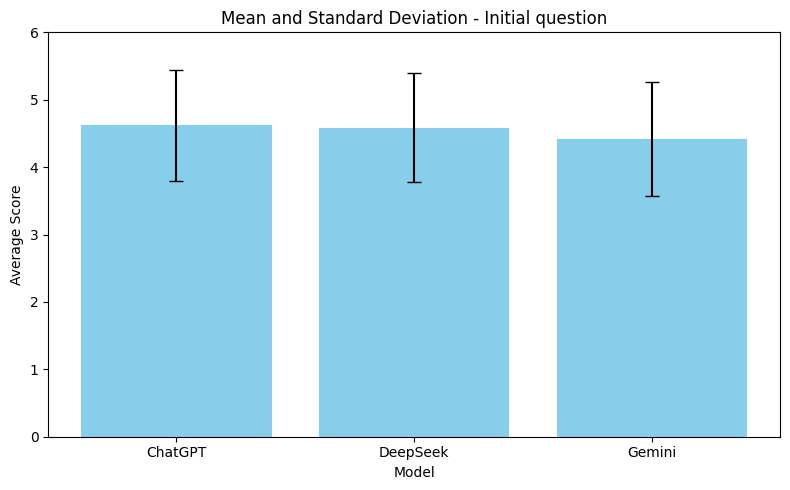

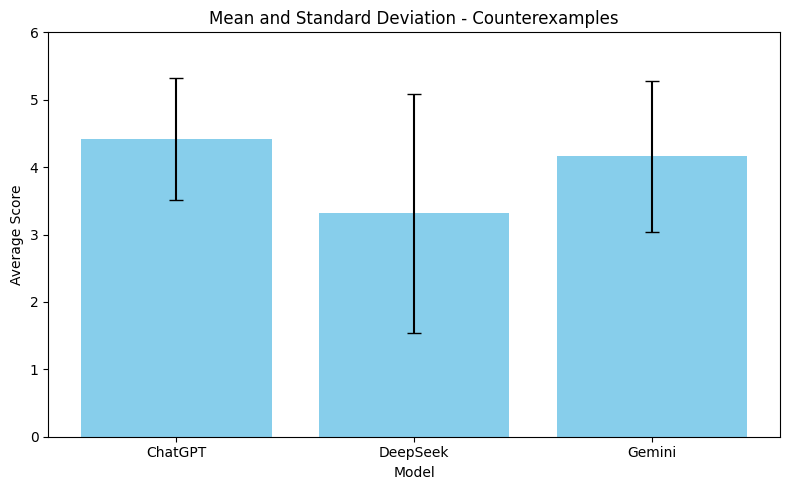

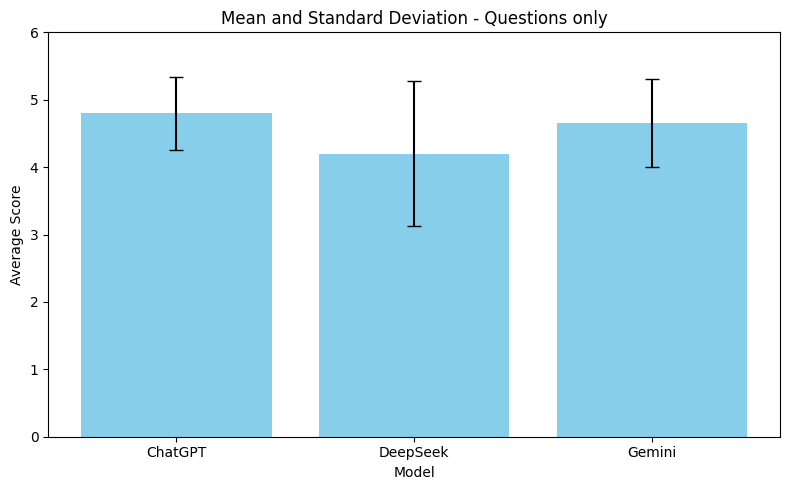

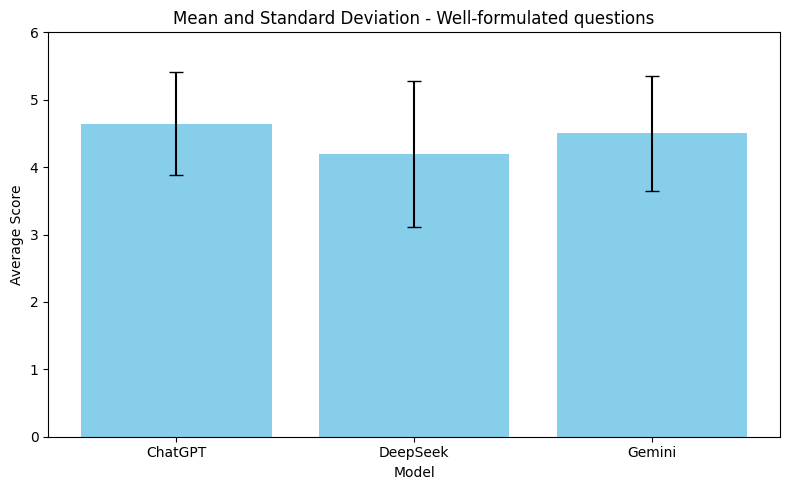

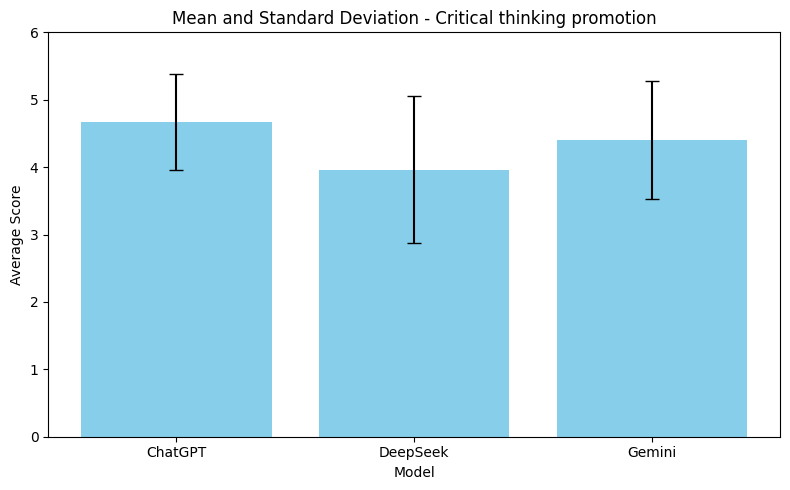

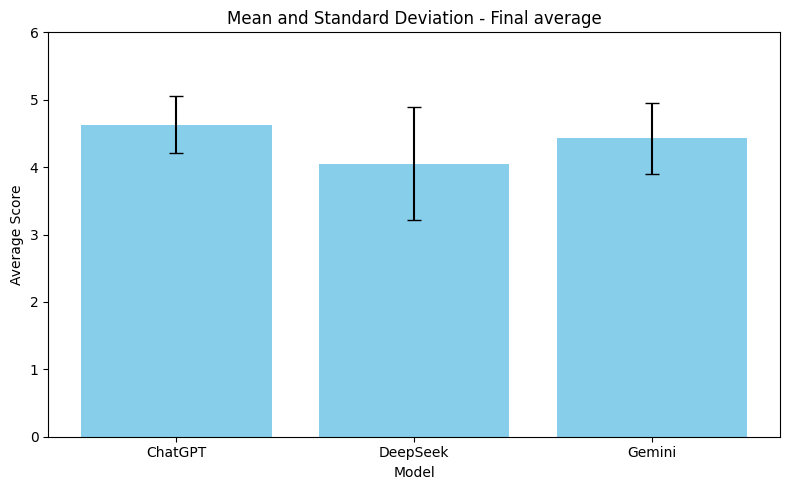

In [ ]:
variaveis = [
    'Apresentou uma questão inicial? (wonder)',
    'Apresentou contra exemplos para testar a validade da resposta dada? (elenchus)',
    'Conduziu apenas com perguntas?',
    'As perguntas foram bem formuladas que incentivam a investigação?',
    'As perguntas promovem pensamento crítico?', 'Média Final'
]


#Tradução das variáveis
traducao_var = {
    'Apresentou uma questão inicial? (wonder)':'Initial question',
    'Apresentou contra exemplos para testar a validade da resposta dada? (elenchus)': 'Counterexamples',
    'Conduziu apenas com perguntas?':'Questions only',
    'As perguntas foram bem formuladas que incentivam a investigação?':'Well-formulated questions',
    'As perguntas promovem pensamento crítico?':'Critical thinking promotion',
    'Média Final': 'Final average'
}

#Tradução dos comportamentos (index do DataFrame)
traducao_index = {
    'Método socrático-chatGPT': 'ChatGPT',
    'Método socrático-deepSeek': 'DeepSeek',
    'Método socrático-gemini': 'Gemini'
}

import matplotlib.pyplot as plt

for var in variaveis:
    dados = estatisticas[var]

    # Traduz o índice para exibição
    x_labels = [traducao_index.get(x, x) for x in dados.index]

    plt.figure(figsize=(8, 5))
    plt.bar(x_labels, dados['Média'], yerr=dados['Desvio Padrão'], capsize=5, color='skyblue')

    plt.title(f"Mean and Standard Deviation - {traducao_var[var]}", fontsize=12)
    plt.ylabel("Average Score")
    plt.xlabel("Model")
    plt.ylim(0, 6)
    plt.grid(axis='y', linestyle='', alpha=0.7)

    plt.tight_layout()
    plt.show()


## Analysis results

## Frequency of Final Decision (Judges' perception) by Model

In [ ]:
import pandas as pd

resultado = frequencia_decisao_por_modelo(df_socratico, 'Decisão Final')

# Transforma o dicionário em DataFrame
tabela_frequencias = pd.DataFrame(resultado).T.fillna(0)

# Exibe a tabela
display(tabela_frequencias)

,Satisfatório,Parcialmente Satisfatório,Insatisfatório
Método socrático-gemini,74.67,20.00,5.33
Método socrático-chatGPT,86.67,9.33,4.00
Método socrático-deepSeek,62.00,26.00,12.00


/tmp/ipython-input-2139079468.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([traducao.get(t.get_text(), t.get_text()) for t in ax.get_xticklabels()])


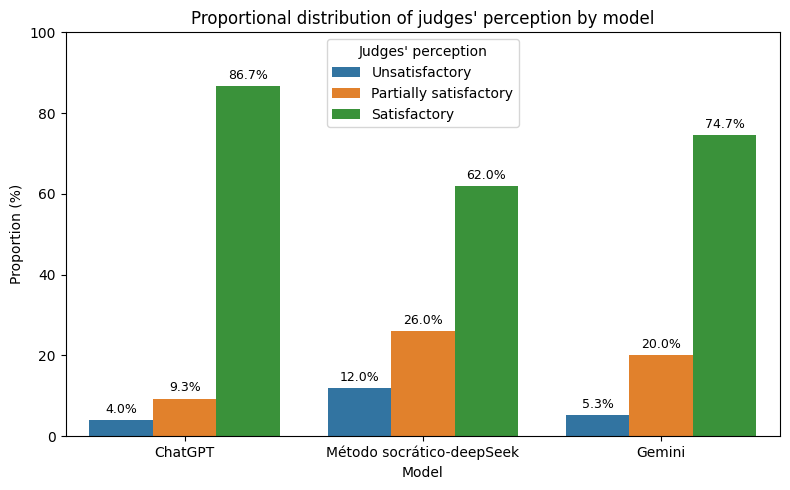

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Dicionários de tradução
traducao = {
    "Método socrático-chatGPT": "ChatGPT",
    "Método socrático-deepSee": "DeepSeek",
    "Método socrático-gemini": "Gemini"
}

traducao_legenda = {
    "Satisfatório": "Satisfactory",
    "Parcialmente Satisfatório": "Partially satisfactory",
    "Insatisfatório": "Unsatisfactory"
}

# Tabela com proporções
tabela = pd.crosstab(
    df_socratico["Comportamento-modelo"],
    df_socratico["Decisão Final"],
    normalize='index'
)

# Long format
df_prop = tabela.reset_index().melt(
    id_vars='Comportamento-modelo',
    var_name='Decisão Final',
    value_name='Proportion'
)

# Tradução da legenda
df_prop["Decisão Final"] = df_prop["Decisão Final"].map(traducao_legenda)

# Converte para %
df_prop["Proportion_pct"] = df_prop["Proportion"] * 100

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=df_prop,
    x="Comportamento-modelo",
    y="Proportion_pct",
    hue="Decisão Final"
)

# Traduz eixo X
ax.set_xticklabels([traducao.get(t.get_text(), t.get_text()) for t in ax.get_xticklabels()])

plt.title("Proportional distribution of judges' perception by model")
plt.ylabel("Proportion (%)")
plt.xlabel("Model")
plt.ylim(0, 100)
plt.legend(title="Judges' perception")

# Adiciona valores percentuais
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # evita mostrar 0%
        ax.text(
            p.get_x() + p.get_width() / 2.,
            height + 1,             # pequeno deslocamento para não encostar na barra
            f'{height:.1f}%',       # já em %
            ha="center", va="bottom", fontsize=9
        )

plt.tight_layout()
plt.show()

## Frequency of “Provided ready-made answer?”

In [ ]:
import pandas as pd

resultado2 = frequencia_decisao_por_modelo(df_socratico, 'Forneceu resposta pronta?')

# Transforma o dicionário em DataFrame
tabela_frequencias2 = pd.DataFrame(resultado2).T.fillna(0)

# Exibe a tabela
print(tabela_frequencias2)

                             Não  Parcialmente    Sim
Método socrático-gemini    96.67          2.00   1.33
Método socrático-chatGPT   98.67          1.33   0.00
Método socrático-deepSeek  43.33         26.67  30.00


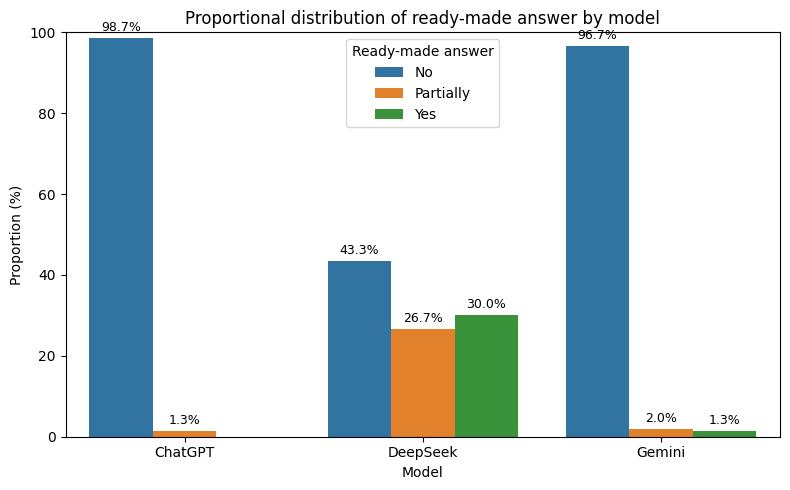

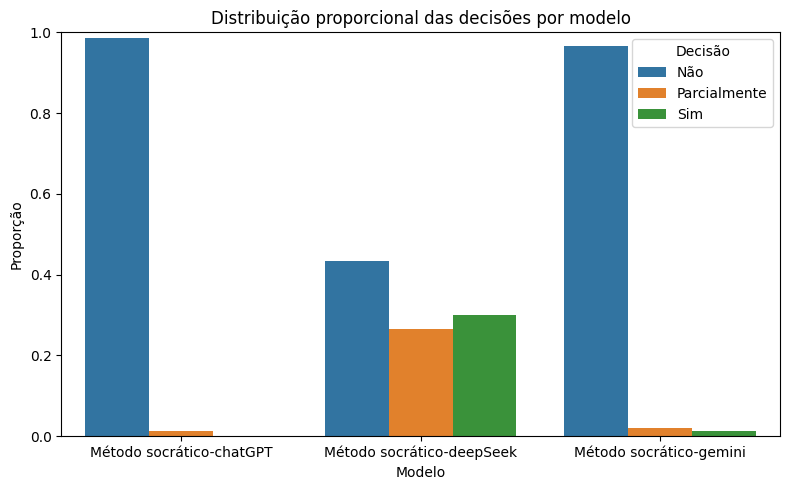

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Dicionários de tradução
traducao_modelo = {
    "Método socrático-chatGPT": "ChatGPT",
    "Método socrático-deepSeek": "DeepSeek",
    "Método socrático-gemini": "Gemini"
}

traducao_resposta = {
    "Sim": "Yes",
    "Parcialmente": "Partially",
    "Não": "No"
}

# Cria tabela com proporções por modelo
tabela = pd.crosstab(
    df_socratico["Comportamento-modelo"],
    df_socratico["Forneceu resposta pronta?"],
    normalize='index'
)

# Converte para long format
df_prop = tabela.reset_index().melt(
    id_vars='Comportamento-modelo',
    var_name='Forneceu resposta pronta?',
    value_name='Proporção'
)

# Traduz labels para exibição
df_prop["Comportamento-modelo"] = df_prop["Comportamento-modelo"].map(traducao_modelo)
df_prop["Forneceu resposta pronta?"] = df_prop["Forneceu resposta pronta?"].map(traducao_resposta)

# Multiplica proporção por 100 para exibir %
df_prop["Proporção_pct"] = df_prop["Proporção"] * 100

# Gráfico de barras empilhadas
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=df_prop,
    x="Comportamento-modelo",
    y="Proporção_pct",
    hue="Forneceu resposta pronta?"
)
plt.title("Proportional distribution of ready-made answer by model")
plt.ylabel("Proportion (%)")
plt.xlabel("Model")
plt.ylim(0, 100)
plt.legend(title="Ready-made answer")

# Adiciona os valores percentuais em cima das barras
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(
            p.get_x() + p.get_width() / 2.,  # centraliza na barra
            height + 1,                      # pequeno deslocamento acima da barra
            f'{height:.1f}%',                # exibe em %
            ha="center", va="bottom", fontsize=9
        )

plt.tight_layout()
plt.show()


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cria tabela com proporções por modelo
tabela = pd.crosstab(df_socratico["Comportamento-modelo"], df_socratico["Forneceu resposta pronta?"], normalize='index')

# Converte para long format para plotar com seaborn
df_prop = tabela.reset_index().melt(id_vars='Comportamento-modelo',
                                    var_name='Forneceu resposta pronta?',
                                    value_name='Proporção')

# Gráfico de barras empilhadas com proporções
plt.figure(figsize=(8, 5))
sns.barplot(data=df_prop, x="Comportamento-modelo", y="Proporção", hue="Forneceu resposta pronta?")
plt.title("Distribuição proporcional das decisões por modelo")
plt.ylabel("Proporção")
plt.xlabel("Modelo")
plt.ylim(0, 1)
plt.legend(title="Decisão")
plt.tight_layout()
plt.show()

##Graphs with Kruskal-Wallis + Dunn's test

Initial question: Kruskal-Wallis H=8.5192, p=0.0141
Initial question: Significant Dunn pairs: [('Gemini', 'ChatGPT')]


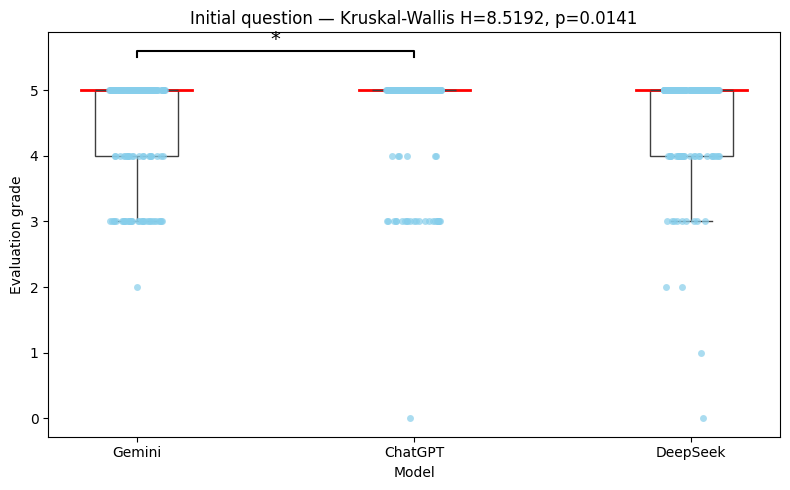

Counterexamples: Kruskal-Wallis H=37.2175, p=0.0000
Counterexamples: Significant Dunn pairs: [('Gemini', 'DeepSeek'), ('ChatGPT', 'DeepSeek')]


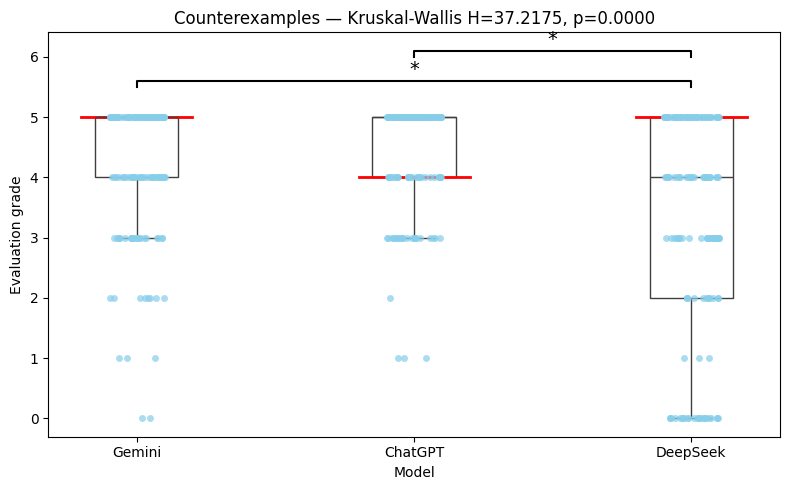

Questions only: Kruskal-Wallis H=40.9931, p=0.0000
Questions only: Significant Dunn pairs: [('Gemini', 'DeepSeek'), ('ChatGPT', 'DeepSeek')]


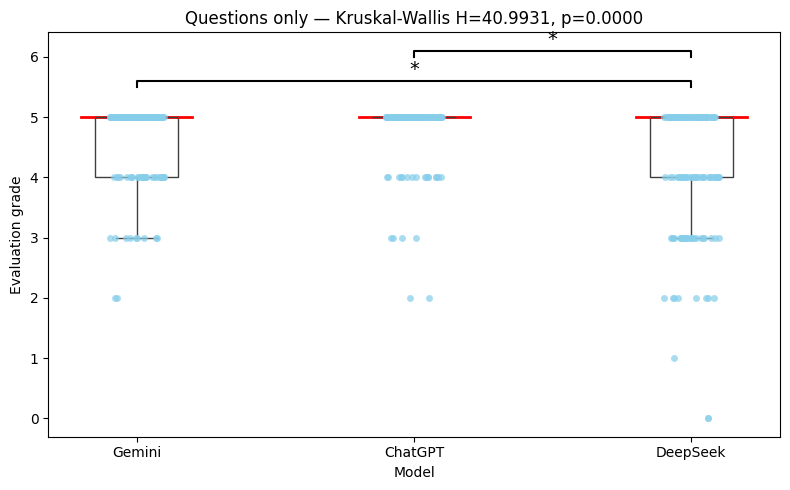

Well-formulated questions: Kruskal-Wallis H=24.0971, p=0.0000
Well-formulated questions: Significant Dunn pairs: [('Gemini', 'DeepSeek'), ('ChatGPT', 'DeepSeek')]


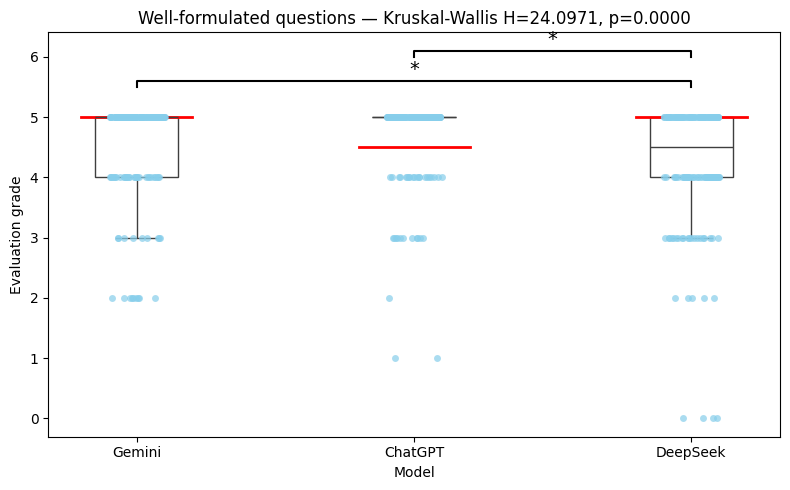

Critical thinking promotion: Kruskal-Wallis H=49.3344, p=0.0000
Critical thinking promotion: Significant Dunn pairs: [('Gemini', 'ChatGPT'), ('Gemini', 'DeepSeek'), ('ChatGPT', 'DeepSeek')]


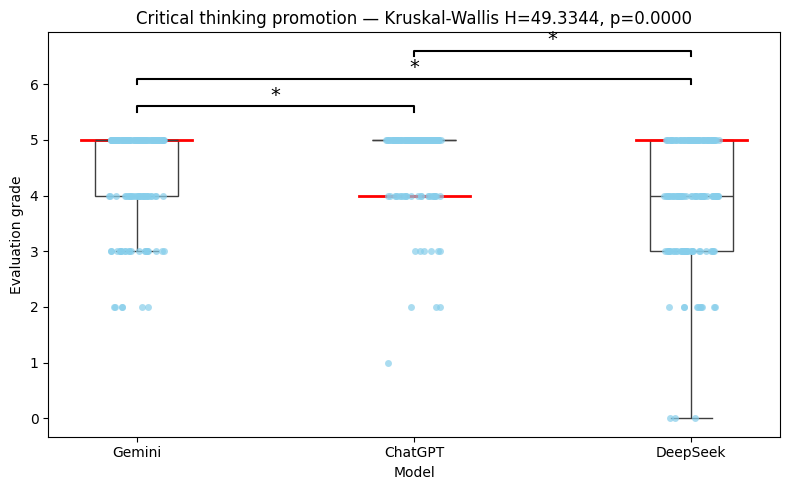

Final average: Kruskal-Wallis H=52.3954, p=0.0000
Final average: Significant Dunn pairs: [('Gemini', 'ChatGPT'), ('Gemini', 'DeepSeek'), ('ChatGPT', 'DeepSeek')]


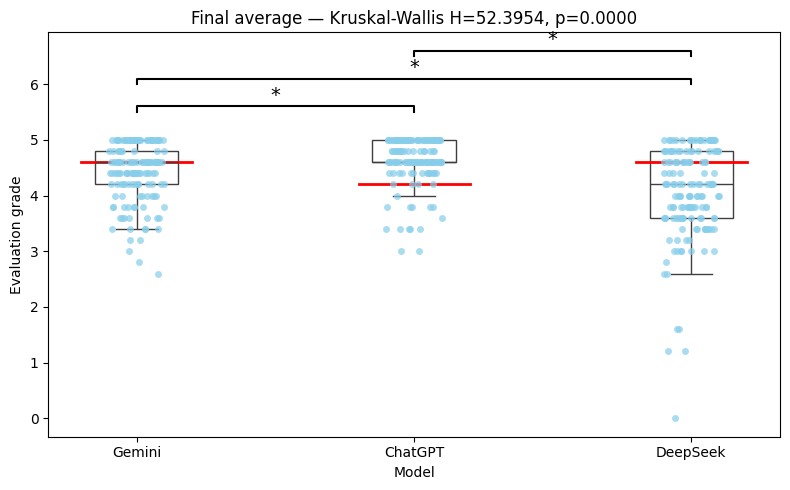

,Variable,H,p
0,Initial question,8.519227,1.412776e-02
1,Counterexamples,37.217507,8.285544e-09
2,Questions only,40.993077,1.254488e-09
3,Well-formulated questions,24.097106,5.853020e-06
4,Critical thinking promotion,49.334398,1.937187e-11
5,Final average,52.395381,4.192640e-12


In [ ]:
df_socratico = ler_csv_corrigindo_numeros_socratico('avaliacoes_socratico.CSV')

###########################Translation
# Tradução dos títulos das colunas
traducao_colunas = {
    'Comportamento-modelo': 'Model',
    'Apresentou uma questão inicial? (wonder)':'Initial question',
    'Apresentou contra exemplos para testar a validade da resposta dada? (elenchus)': 'Counterexamples',
    'Conduziu apenas com perguntas?':'Questions only',
    'As perguntas foram bem formuladas que incentivam a investigação?':'Well-formulated questions',
    'As perguntas promovem pensamento crítico?':'Critical thinking promotion',
    'Média Final': 'Final average'
}

# Tradução de termos específicos nas linhas
traducao_linhas = {
    "Método socrático-chatGPT": "ChatGPT",
    "Método socrático-deepSeek": "DeepSeek",
    "Método socrático-gemini": "Gemini"
}


###Tradução das colunas
df_socratico = df_socratico.rename(columns=traducao_colunas)

###Tradução das linhas
df_socratico['Model'] = df_socratico['Model'].replace(traducao_linhas)

variables = [
    'Initial question','Counterexamples','Questions only','Well-formulated questions','Critical thinking promotion', 'Final average'
]
for var in variables:
    # Convert to string, replace comma with dot, then convert to float
    df_socratico[var] = df_socratico[var].astype(str).str.replace(',', '.').astype(float)

plot_variables_with_dunn(df_socratico, variables)

## Chi-square test in the end of this colab

# Analysis of categorical variables


##Examples - Final Decision (Judges' perception)

In [ ]:
# Caminho para o arquivo CSV
df_exemplos = ler_csv_corrigindo_numeros('avaliacoes_exemplos.CSV')

In [ ]:
# Criar tabela de contingência
tabela = pd.crosstab(df_exemplos["Comportamento-modelo"], df_exemplos["Decisão Final"])
print("\n📊 Frequência absoluta por Modelo:")
print(tabela)

# Frequência percentual
tabela_perc = pd.crosstab(df_exemplos["Comportamento-modelo"], df_exemplos["Decisão Final"], normalize="index") * 100
print("\n📊 Frequência percentual por ferramenta:")
print(tabela_perc.round(2))


📊 Frequência absoluta por Modelo:
Decisão Final         Insatisfatório  Parcialmente Satisfatório  Satisfatório
Comportamento-modelo                                                         
Exemplos-chatGPT                  11                         33           106
Exemplos-deepSeek                 27                         58            65
Exemplos-gemini                    8                         42           100

📊 Frequência percentual por ferramenta:
Decisão Final         Insatisfatório  Parcialmente Satisfatório  Satisfatório
Comportamento-modelo                                                         
Exemplos-chatGPT                7.33                      22.00         70.67
Exemplos-deepSeek              18.00                      38.67         43.33
Exemplos-gemini                 5.33                      28.00         66.67


In [ ]:
from scipy.stats import chi2_contingency

# Teste Qui-quadrado global
qui2, p_valor, dof, esperado = chi2_contingency(tabela)

print("\n🔹 Teste Qui-quadrado Global - Exemplos - Decisão Final")
print(f"Estatística Qui² = {qui2:.4f}")
print(f"p-valor = {p_valor:.6f}")
print(f"Graus de liberdade = {dof}")

if p_valor < 0.05:
    print("💥 Diferença estatisticamente significativa entre as ferramentas!")
else:
    print("🧘‍♀️ Não há diferença significativa entre as ferramentas.")


🔹 Teste Qui-quadrado Global - Exemplos - Decisão Final
Estatística Qui² = 31.6979
p-valor = 0.000002
Graus de liberdade = 4
💥 Diferença estatisticamente significativa entre as ferramentas!


In [ ]:
# Aplicar teste par-a-par com Bonferroni
resultados_bonferroni = qui_quadrado_par_a_par(df_exemplos, "Comportamento-modelo", "Decisão Final")

print("\n🔹 Comparações par-a-par com Bonferroni:")
print(resultados_bonferroni)

Total de pares:  3

🔹 Comparações par-a-par com Bonferroni:
       Ferramenta 1       Ferramenta 2     Qui²   p-valor  p Bonferroni  \
2  Exemplos-chatGPT  Exemplos-deepSeek  23.4354  0.000008      0.000024   
1   Exemplos-gemini  Exemplos-deepSeek  20.2985  0.000039      0.000117   
0   Exemplos-gemini   Exemplos-chatGPT   1.7284  0.421380      1.000000   

   Significativo  
2           True  
1           True  
0          False  


##Examples - Immediate solution (non desirable)

In [ ]:
# Criar tabela de contingência
tabela = pd.crosstab(df_exemplos["Comportamento-modelo"], df_exemplos["Forneceu resposta pronta?"])
print("\n📊 Frequência absoluta por Modelo:")
print(tabela)

# Frequência percentual
tabela_perc = pd.crosstab(df_exemplos["Comportamento-modelo"], df_exemplos["Forneceu resposta pronta?"], normalize="index") * 100
print("\n📊 Frequência percentual por ferramenta:")
print(tabela_perc.round(2))


📊 Frequência absoluta por Modelo:
Forneceu resposta pronta?  Não  Parcialmente  Sim
Comportamento-modelo                             
Exemplos-chatGPT            69            49   32
Exemplos-deepSeek           13            31  106
Exemplos-gemini            138             9    3

📊 Frequência percentual por ferramenta:
Forneceu resposta pronta?    Não  Parcialmente    Sim
Comportamento-modelo                                 
Exemplos-chatGPT           46.00         32.67  21.33
Exemplos-deepSeek           8.67         20.67  70.67
Exemplos-gemini            92.00          6.00   2.00


In [ ]:
from scipy.stats import chi2_contingency

# Teste Qui-quadrado global
qui2, p_valor, dof, esperado = chi2_contingency(tabela)

print("\n🔹 Teste Qui-quadrado Global - Exemplos - Forneceu resposta pronta?")
print(f"Estatística Qui² = {qui2:.4f}")
print(f"p-valor = {p_valor:.6f}")
print(f"Graus de liberdade = {dof}")

if p_valor < 0.05:
    print("💥 Diferença estatisticamente significativa entre as ferramentas!")
else:
    print("🧘‍♀️ Não há diferença significativa entre as ferramentas.")


🔹 Teste Qui-quadrado Global - Exemplos - Forneceu resposta pronta?
Estatística Qui² = 254.0169
p-valor = 0.000000
Graus de liberdade = 4
💥 Diferença estatisticamente significativa entre as ferramentas!


In [ ]:
# Aplicar teste par-a-par com Bonferroni
resultados_bonferroni = qui_quadrado_par_a_par(df_exemplos, "Comportamento-modelo", "Forneceu resposta pronta?")

print("\n🔹 Comparações par-a-par com Bonferroni:")
print(resultados_bonferroni)

Total de pares:  3

🔹 Comparações par-a-par com Bonferroni:
       Ferramenta 1       Ferramenta 2      Qui²  p-valor  p Bonferroni  \
0   Exemplos-gemini   Exemplos-chatGPT   74.6148      0.0           0.0   
1   Exemplos-gemini  Exemplos-deepSeek  212.9071      0.0           0.0   
2  Exemplos-chatGPT  Exemplos-deepSeek   81.9751      0.0           0.0   

   Significativo  
0           True  
1           True  
2           True  


##Explanations and Analogies - Final Decision (Judges' perception)

In [ ]:
# Caminho para o arquivo CSV
df_explicacoes = ler_csv_corrigindo_numeros_explicacoes('avaliacoes_explicacoes.CSV')

In [ ]:
# Criar tabela de contingência
tabela = pd.crosstab(df_explicacoes["Comportamento-modelo"], df_explicacoes["Decisão Final"])
print("\n📊 Frequência absoluta por Modelo:")
print(tabela)

# Frequência percentual
tabela_perc = pd.crosstab(df_explicacoes["Comportamento-modelo"], df_explicacoes["Decisão Final"], normalize="index") * 100
print("\n📊 Frequência percentual por ferramenta:")
print(tabela_perc.round(2))


📊 Frequência absoluta por Modelo:
Decisão Final                    Insatisfatório  Parcialmente Satisfatório  \
Comportamento-modelo                                                         
Explicações e Analogias-chatGPT               1                         39   
Explicações e Analogias-deepSee              25                         59   
Explicações e Analogias-gemini                3                         46   

Decisão Final                    Satisfatório  
Comportamento-modelo                           
Explicações e Analogias-chatGPT           110  
Explicações e Analogias-deepSee            66  
Explicações e Analogias-gemini            100  

📊 Frequência percentual por ferramenta:
Decisão Final                    Insatisfatório  Parcialmente Satisfatório  \
Comportamento-modelo                                                         
Explicações e Analogias-chatGPT            0.67                      26.00   
Explicações e Analogias-deepSee           16.67            

In [ ]:
from scipy.stats import chi2_contingency

# Teste Qui-quadrado global
qui2, p_valor, dof, esperado = chi2_contingency(tabela)

print("\n🔹 Teste Qui-quadrado Global - Explicações e Analogias - Decisão Final")
print(f"Estatística Qui² = {qui2:.4f}")
print(f"p-valor = {p_valor:.6f}")
print(f"Graus de liberdade = {dof}")

if p_valor < 0.05:
    print("💥 Diferença estatisticamente significativa entre as ferramentas!")
else:
    print("🧘‍♀️ Não há diferença significativa entre as ferramentas.")


🔹 Teste Qui-quadrado Global - Explicações e Analogias - Decisão Final
Estatística Qui² = 52.4613
p-valor = 0.000000
Graus de liberdade = 4
💥 Diferença estatisticamente significativa entre as ferramentas!


In [ ]:
# Aplicar teste par-a-par com Bonferroni
resultados_bonferroni = qui_quadrado_par_a_par(df_explicacoes, "Comportamento-modelo", "Decisão Final")

print("\n🔹 Comparações par-a-par com Bonferroni:")
print(resultados_bonferroni)

Total de pares:  3

🔹 Comparações par-a-par com Bonferroni:
                      Ferramenta 1                     Ferramenta 2     Qui²  \
2  Explicações e Analogias-chatGPT  Explicações e Analogias-deepSee  37.2355   
1   Explicações e Analogias-gemini  Explicações e Analogias-deepSee  25.8560   
0   Explicações e Analogias-gemini  Explicações e Analogias-chatGPT   2.0493   

    p-valor  p Bonferroni  Significativo  
2  0.000000      0.000000           True  
1  0.000002      0.000007           True  
0  0.358915      1.000000          False  


##Explanations and Analogies - Immediate solution (non desirable)

In [ ]:
# Criar tabela de contingência
tabela = pd.crosstab(df_explicacoes["Comportamento-modelo"], df_explicacoes["Forneceu resposta pronta?"])
print("\n📊 Frequência absoluta por Modelo:")
print(tabela)

# Frequência percentual
tabela_perc = pd.crosstab(df_explicacoes["Comportamento-modelo"], df_explicacoes["Forneceu resposta pronta?"], normalize="index") * 100
print("\n📊 Frequência percentual por ferramenta:")
print(tabela_perc.round(2))


📊 Frequência absoluta por Modelo:
Forneceu resposta pronta?        Não  Parcialmente  Sim
Comportamento-modelo                                   
Explicações e Analogias-chatGPT  120            26    4
Explicações e Analogias-deepSee   22            35   93
Explicações e Analogias-gemini   129            21    0

📊 Frequência percentual por ferramenta:
Forneceu resposta pronta?          Não  Parcialmente    Sim
Comportamento-modelo                                       
Explicações e Analogias-chatGPT  80.00         17.33   2.67
Explicações e Analogias-deepSee  14.67         23.33  62.00
Explicações e Analogias-gemini   86.00         14.00   0.00


In [ ]:
from scipy.stats import chi2_contingency

# Teste Qui-quadrado global
qui2, p_valor, dof, esperado = chi2_contingency(tabela)

print("\n🔹 Teste Qui-quadrado Global - Explicações e Analogias - Forneceu resposta pronta?")
print(f"Estatística Qui² = {qui2:.4f}")
print(f"p-valor = {p_valor:.6f}")
print(f"Graus de liberdade = {dof}")

if p_valor < 0.05:
    print("💥 Diferença estatisticamente significativa entre as ferramentas!")
else:
    print("🧘‍♀️ Não há diferença significativa entre as ferramentas.")


🔹 Teste Qui-quadrado Global - Explicações e Analogias - Forneceu resposta pronta?
Estatística Qui² = 252.6579
p-valor = 0.000000
Graus de liberdade = 4
💥 Diferença estatisticamente significativa entre as ferramentas!


In [ ]:
# Aplicar teste par-a-par com Bonferroni
resultados_bonferroni = qui_quadrado_par_a_par(df_explicacoes, "Comportamento-modelo", "Forneceu resposta pronta?")

print("\n🔹 Comparações par-a-par com Bonferroni:")
print(resultados_bonferroni)

Total de pares:  3

🔹 Comparações par-a-par com Bonferroni:
                      Ferramenta 1                     Ferramenta 2      Qui²  \
1   Explicações e Analogias-gemini  Explicações e Analogias-deepSee  172.3212   
2  Explicações e Analogias-chatGPT  Explicações e Analogias-deepSee  150.6215   
0   Explicações e Analogias-gemini  Explicações e Analogias-chatGPT    4.8572   

    p-valor  p Bonferroni  Significativo  
1  0.000000      0.000000           True  
2  0.000000      0.000000           True  
0  0.088159      0.264478          False  


## Socratic Method - Final Decision (judges' perception)

In [ ]:
# Caminho para o arquivo CSV
df_socratico = ler_csv_corrigindo_numeros_socratico('avaliacoes_socratico.CSV')

In [ ]:
# Criar tabela de contingência
tabela = pd.crosstab(df_socratico["Comportamento-modelo"], df_socratico["Decisão Final"])
print("\n📊 Frequência absoluta por Modelo:")
print(tabela)

# Frequência percentual
tabela_perc = pd.crosstab(df_socratico["Comportamento-modelo"], df_socratico["Decisão Final"], normalize="index") * 100
print("\n📊 Frequência percentual por ferramenta:")
print(tabela_perc.round(2))


📊 Frequência absoluta por Modelo:
Decisão Final              Insatisfatório  Parcialmente Satisfatório  \
Comportamento-modelo                                                   
Método socrático-chatGPT                6                         14   
Método socrático-deepSeek              18                         39   
Método socrático-gemini                 8                         30   

Decisão Final              Satisfatório  
Comportamento-modelo                     
Método socrático-chatGPT            130  
Método socrático-deepSeek            93  
Método socrático-gemini             112  

📊 Frequência percentual por ferramenta:
Decisão Final              Insatisfatório  Parcialmente Satisfatório  \
Comportamento-modelo                                                   
Método socrático-chatGPT             4.00                       9.33   
Método socrático-deepSeek           12.00                      26.00   
Método socrático-gemini              5.33                      20

In [ ]:
from scipy.stats import chi2_contingency

# Teste Qui-quadrado global
qui2, p_valor, dof, esperado = chi2_contingency(tabela)

print("\n🔹 Teste Qui-quadrado Global - Método Socrático - Decisão Final")
print(f"Estatística Qui² = {qui2:.4f}")
print(f"p-valor = {p_valor:.6f}")
print(f"Graus de liberdade = {dof}")

if p_valor < 0.05:
    print("💥 Diferença estatisticamente significativa entre as ferramentas!")
else:
    print("🧘‍♀️ Não há diferença significativa entre as ferramentas.")


🔹 Teste Qui-quadrado Global - Método Socrático - Decisão Final
Estatística Qui² = 25.4717
p-valor = 0.000040
Graus de liberdade = 4
💥 Diferença estatisticamente significativa entre as ferramentas!


In [ ]:
# Aplicar teste par-a-par com Bonferroni
resultados_bonferroni = qui_quadrado_par_a_par(df_socratico, "Comportamento-modelo", "Decisão Final")

print("\n🔹 Comparações par-a-par com Bonferroni:")
print(resultados_bonferroni)

Total de pares:  3

🔹 Comparações par-a-par com Bonferroni:
               Ferramenta 1               Ferramenta 2     Qui²   p-valor  \
2  Método socrático-chatGPT  Método socrático-deepSeek  23.9315  0.000006   
0   Método socrático-gemini   Método socrático-chatGPT   7.4427  0.024201   
1   Método socrático-gemini  Método socrático-deepSeek   6.7810  0.033691   

   p Bonferroni  Significativo  
2      0.000019           True  
0      0.072602          False  
1      0.101073          False  


##Socratic Method - Immediate solution (non desirable)

In [ ]:
# Criar tabela de contingência
tabela = pd.crosstab(df_socratico["Comportamento-modelo"], df_socratico["Forneceu resposta pronta?"])
print("\n📊 Frequência absoluta por Modelo:")
print(tabela)

# Frequência percentual
tabela_perc = pd.crosstab(df_socratico["Comportamento-modelo"], df_socratico["Forneceu resposta pronta?"], normalize="index") * 100
print("\n📊 Frequência percentual por ferramenta:")
print(tabela_perc.round(2))


📊 Frequência absoluta por Modelo:
Forneceu resposta pronta?  Não  Parcialmente  Sim
Comportamento-modelo                             
Método socrático-chatGPT   148             2    0
Método socrático-deepSeek   65            40   45
Método socrático-gemini    145             3    2

📊 Frequência percentual por ferramenta:
Forneceu resposta pronta?    Não  Parcialmente    Sim
Comportamento-modelo                                 
Método socrático-chatGPT   98.67          1.33   0.00
Método socrático-deepSeek  43.33         26.67  30.00
Método socrático-gemini    96.67          2.00   1.33


In [ ]:
from scipy.stats import chi2_contingency

# Teste Qui-quadrado global
qui2, p_valor, dof, esperado = chi2_contingency(tabela)

print("\n🔹 Teste Qui-quadrado Global - Método Socrático - Forneceu resposta pronta?")
print(f"Estatística Qui² = {qui2:.4f}")
print(f"p-valor = {p_valor:.6f}")
print(f"Graus de liberdade = {dof}")

if p_valor < 0.05:
    print("💥 Diferença estatisticamente significativa entre as ferramentas!")
else:
    print("🧘‍♀️ Não há diferença significativa entre as ferramentas.")


🔹 Teste Qui-quadrado Global - Método Socrático - Forneceu resposta pronta?
Estatística Qui² = 182.1892
p-valor = 0.000000
Graus de liberdade = 4
💥 Diferença estatisticamente significativa entre as ferramentas!


In [ ]:
# Aplicar teste par-a-par com Bonferroni
resultados_bonferroni = qui_quadrado_par_a_par(df_socratico, "Comportamento-modelo", "Forneceu resposta pronta?")

print("\n🔹 Comparações par-a-par com Bonferroni:")
print(resultados_bonferroni)

Total de pares:  3

🔹 Comparações par-a-par com Bonferroni:
               Ferramenta 1               Ferramenta 2      Qui²   p-valor  \
1   Método socrático-gemini  Método socrático-deepSeek  101.6538  0.000000   
2  Método socrático-chatGPT  Método socrático-deepSeek  111.7237  0.000000   
0   Método socrático-gemini   Método socrático-chatGPT    2.2307  0.327798   

   p Bonferroni  Significativo  
1      0.000000           True  
2      0.000000           True  
0      0.983393          False  


## Graphs

In [ ]:

import pandas as pd
examples=pd.read_csv(
    "avaliacoes_exemplos.CSV",
    sep=";",
    engine="python",
    encoding="utf-8"  # or try "latin1" if utf-8 fails
)